In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
adjusted_rand_score, normalized_mutual_info_score,
accuracy_score, confusion_matrix, classification_report,
roc_auc_score, roc_curve, f1_score, precision_score, recall_score)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [94]:
file_path = r'C:\Users\14624\Desktop\Qinbin expressway+ weather data'
df = pd.read_excel(file_path + '.xlsx')

In [95]:
print("\n" + "="*50)
print("DATA CHECK")
print("="*50)

print(f"Shape: {df.shape}")
print("\nColumns:")
for col in df.columns:
    print(f"  {col}")

print("\nSample data:")
print(df.head())

print("\nQuick stats:")
print(df.describe())

print("\nData basic information:")
print(df.info())

print("\nDescriptive statistics:")
print(df.describe())

# Missing value check
print("\nMissing values check:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.any() else "All good")

# Clean column names
print("\nStandardizing column names...")
df.columns = df.columns.str.strip().str.lower().str.replace(r'\s+|[^\w_]', '_', regex=True)
print(f"New columns: {df.columns.tolist()}")


DATA CHECK
Shape: (372, 16)

Columns:
  日期
  时段
  是否为节假日
  北往南车流量
  南往北车流量
  累计总车流量
  北部气温(°C)
  天气代码()
  北部天气情况分值
  北部降雨量(mm)
  北部10米风速(m/s)
  南部气温(°C)
  南部天气代码()
  南部天气情况分值
  南部降雨量(mm)
  南部10米风速(m/s)

Sample data:
      日期  时段  是否为节假日  北往南车流量  南往北车流量  累计总车流量  北部气温(°C) 天气代码()  北部天气情况分值  \
0  10.01   2       1    2469    3087    5556     23.50      晴        10   
1  10.01   4       1    2758    1651    4409     23.20      晴        10   
2  10.01   6       1    2030    1935    3965     22.85      晴        10   
3  10.01   8       1    3173    2936    6109     22.45      晴        10   
4  10.01  10       1    3845    2799    6644     22.80      晴        10   

   北部降雨量(mm)  北部10米风速(m/s)  南部气温(°C) 南部天气代码()  南部天气情况分值  南部降雨量(mm)  \
0        0.0          4.92     20.61        晴        10        0.0   
1        0.0          4.72     19.91        晴        10        0.0   
2        0.0          4.32     19.61        晴        10        0.0   
3        0.0          4.27     19.96        晴       

In [96]:
column_mapping = {
'日期': 'Date_Original',
'时段': 'Time_Slot',
'是否为节假日': 'Is_Holiday',
'北往南车流量': 'North_to_South_Flow',
'南往北车流量': 'South_to_North_Flow',
'累计总车流量': 'Total_Traffic_Flow',
'北部气温(°C)': 'North_Temperature',
'天气代码()': 'Weather_Code',
'北部天气情况分值': 'North_Weather_Score',
'北部降雨量(mm)': 'North_Rainfall',
'北部10米风速(m/s)': 'North_Wind_Speed',
'南部气温(°C)': 'South_Temperature',
'南部天气代码()': 'South_Weather_Code',
'南部天气情况分值': 'South_Weather_Score',
'南部降雨量(mm)': 'South_Rainfall',
'南部10米风速(m/s)': 'South_Wind_Speed',
'北部气温__c_': 'North_Temperature',
'天气代码__': 'Weather_Code',  
'北部降雨量_mm_': 'North_Rainfall',
'北部10米风速_m_s_': 'North_Wind_Speed',
'南部气温__c_': 'South_Temperature',
'南部天气代码__': 'South_Weather_Code',
'南部降雨量_mm_': 'South_Rainfall',
'南部10米风速_m_s_': 'South_Wind_Speed'
}
df = df.rename(columns=column_mapping)

In [97]:
print("\nCreating traffic level labels...")
def assign_traffic_label(row):
    total = row['Total_Traffic_Flow']
    if total < 3000:
        return 0 # Low flow
    elif total < 4500:
        return 1 # Medium flow
    elif total < 6000:
        return 2 # High flow
    else:
        return 3 # Peak

df['Traffic_Level'] = df.apply(assign_traffic_label, axis=1)
print(f"Traffic level distribution: {df['Traffic_Level'].value_counts().sort_index().to_dict()}")


Creating traffic level labels...
Traffic level distribution: {0: 280, 1: 52, 2: 25, 3: 15}


In [98]:
print("\nProcessing time information...")
def time_slot_to_period(slot):
    if slot == 2:
        return '02:00-04:00'
    elif slot == 4:
        return '04:00-06:00'
    elif slot == 6:
        return '06:00-08:00'
    elif slot == 8:
        return '08:00-10:00'
    elif slot == 10:
        return '10:00-12:00'
    elif slot == 12:
        return '12:00-14:00'
    elif slot == 14:
        return '14:00-16:00'
    elif slot == 16:
        return '16:00-18:00'
    elif slot == 18:
        return '18:00-20:00'
    elif slot == 20:
        return '20:00-22:00'
    elif slot == 22:
        return '22:00-24:00'
    else:
        return '00:00-02:00'

df['Time_Period'] = df['Time_Slot'].apply(time_slot_to_period)


Processing time information...


In [99]:
print("Creating date features...")
try:
    # Convert Date_Original to proper date (only date part)
    # Date_Original格式如10.01，需要提取月和日
    def parse_date(val):
        """解析日期格式如10.01"""
        if pd.isna(val):
            return pd.NaT
        
        val_str = str(val)
        if '.' in val_str:
            parts = val_str.split('.')
            month = parts[0].zfill(2)
            day = parts[1].split()[0].zfill(2) if ' ' in parts[1] else parts[1].zfill(2)
            return pd.Timestamp(f'2025-{month}-{day}')
        else:
            # 尝试其他格式
            return pd.to_datetime(val, errors='coerce')
    
    df['Date'] = df['Date_Original'].apply(parse_date)
    print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    
    # 提取星期特征
    df['Weekday'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = (df['Weekday'] >= 5).astype(int)
    df['Is_Weekday'] = (df['Weekday'] < 5).astype(int)
    print("Date features created successfully")
    
except Exception as e:
    print(f"Date processing error: {e}")
    print("Creating simulated dates...")
    # 创建模拟的日期序列（只有日期，没有时间）
    days_needed = len(df) // 12  # 假设每天12个时间段
    df['Date'] = pd.date_range(start='2025-10-01', periods=days_needed, freq='D')
    # 重复每个日期12次
    df['Date'] = np.repeat(df['Date'].iloc[:days_needed], 12)[:len(df)]
    df['Weekday'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = (df['Weekday'] >= 5).astype(int)
    df['Is_Weekday'] = (df['Weekday'] < 5).astype(int)

Creating date features...
Date range: 2025-10-01 to 2025-10-31
Date features created successfully


In [100]:
print("Creating date features...")
try:
    df['Weekday'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = (df['Weekday'] >= 5).astype(int)
    df['Is_Weekday'] = (df['Weekday'] < 5).astype(int)
    print("Date features created successfully")
except Exception as e:
    print(f"Date processing error: {e}")
    # Create simulated dates
    df['Weekday'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = (df['Weekday'] >= 5).astype(int)
    df['Is_Weekday'] = (df['Weekday'] < 5).astype(int)
    


Creating date features...
Date features created successfully


In [101]:
print("Actual column names:")
print(df.columns.tolist())
print("\n" + "="*50)

Actual column names:
['Date_Original', 'Time_Slot', 'Is_Holiday', 'North_to_South_Flow', 'South_to_North_Flow', 'Total_Traffic_Flow', 'North_Temperature', 'Weather_Code', 'North_Weather_Score', 'North_Rainfall', 'North_Wind_Speed', 'South_Temperature', 'South_Weather_Code', 'South_Weather_Score', 'South_Rainfall', 'South_Wind_Speed', 'Traffic_Level', 'Time_Period', 'Date', 'Weekday', 'Is_Weekend', 'Is_Weekday']



In [102]:
print("Creating derived features...")
df['Total_Temperature_Diff'] = df['North_Temperature'] - df['South_Temperature']
df['Total_Weather_Score'] = (df['North_Weather_Score'] + df['South_Weather_Score']) / 2
df['Total_Rainfall'] = df['North_Rainfall'] + df['South_Rainfall']
df['Total_Wind_Speed'] = (df['North_Wind_Speed'] + df['South_Wind_Speed']) / 2

print("\nProcessed data structure:")
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 rows of data:")
print(df[['Date', 'Time_Period', 'Is_Holiday', 'North_to_South_Flow', 
          'South_to_North_Flow', 'Total_Traffic_Flow', 'Traffic_Level',
          'North_Temperature', 'South_Temperature', 'Weekday', 'Is_Weekend']].head())


Creating derived features...

Processed data structure:
Dataset shape: (372, 26)

Column names: ['Date_Original', 'Time_Slot', 'Is_Holiday', 'North_to_South_Flow', 'South_to_North_Flow', 'Total_Traffic_Flow', 'North_Temperature', 'Weather_Code', 'North_Weather_Score', 'North_Rainfall', 'North_Wind_Speed', 'South_Temperature', 'South_Weather_Code', 'South_Weather_Score', 'South_Rainfall', 'South_Wind_Speed', 'Traffic_Level', 'Time_Period', 'Date', 'Weekday', 'Is_Weekend', 'Is_Weekday', 'Total_Temperature_Diff', 'Total_Weather_Score', 'Total_Rainfall', 'Total_Wind_Speed']

First 5 rows of data:
        Date  Time_Period  Is_Holiday  North_to_South_Flow  \
0 2025-10-01  02:00-04:00           1                 2469   
1 2025-10-01  04:00-06:00           1                 2758   
2 2025-10-01  06:00-08:00           1                 2030   
3 2025-10-01  08:00-10:00           1                 3173   
4 2025-10-01  10:00-12:00           1                 3845   

   South_to_North_Flow  Tot

In [103]:
"""
Step 3: Data Preprocessing and Feature Engineering - Final Version
"""

print("\nStep 3: Data Preprocessing and Feature Engineering")
print("="*50)

# Check original data
print("Data preview:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

# ==================== 3.1 Create datetime features ====================
print("\n3.1 Creating datetime features...")

# Check actual values
print(f"Date_Original first values: {df['Date_Original'].head().tolist()}")
print(f"Time_Slot first values: {df['Time_Slot'].head().tolist()}")

# Fix date format
def fix_date_format(date_val):
    """Fix date format"""
    # date_val might be in format like 10.01
    if isinstance(date_val, (int, float)):
        date_str = str(date_val)
    else:
        date_str = str(date_val)
    
    # Handle format like 10.01
    if '.' in date_str:
        month_day = date_str.split('.')
        if len(month_day) >= 2:
            month = month_day[0].zfill(2)
            day = month_day[1].zfill(2)
            return f"2025-{month}-{day}"
    
    return date_str

# Apply date fix
df['Fixed_Date'] = df['Date_Original'].apply(fix_date_format)
print(f"Fixed date first values: {df['Fixed_Date'].head().tolist()}")

# Handle hour 24 issue
def create_datetime(row):
    """Create correct datetime"""
    date_str = row['Fixed_Date']
    hour = row['Time_Slot']
    
    # Convert hour 24 to next day 00:00
    if hour == 24:
        date_obj = pd.to_datetime(date_str)
        date_obj = date_obj + pd.Timedelta(days=1)
        hour = 0
    else:
        date_obj = pd.to_datetime(date_str)
    
    # Set hour
    date_obj = date_obj.replace(hour=int(hour))
    
    return date_obj, hour

# Create datetime columns
date_times = []
adjusted_hours = []

for idx, row in df.iterrows():
    datetime_obj, adj_hour = create_datetime(row)
    date_times.append(datetime_obj)
    adjusted_hours.append(adj_hour)

df['Datetime'] = date_times
df['Adjusted_Hour'] = adjusted_hours

print(f"Datetime range: {df['Datetime'].min()} to {df['Datetime'].max()}")

# Extract time features
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Adjusted_Hour']  # Use adjusted hour
df['Weekday'] = df['Datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Create weekend feature
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

print("✓ Time features created")
print(f"  Date range: {df['Datetime'].min().date()} to {df['Datetime'].max().date()}")
print(f"  Hour range: {df['Hour'].min()} to {df['Hour'].max()}")
print(f"  Weekend days: {df['Is_Weekend'].sum()}")

# ==================== 3.2 Add holiday features ====================
print("\n3.2 Adding holiday features...")

# Add National Day holiday info (October)
def is_holiday(month, day):
    """Check if holiday"""
    # National Day: Oct 1-7
    if month == 10 and 1 <= day <= 7:
        return 1
    return 0

df['Is_Holiday'] = df.apply(lambda row: is_holiday(row['Month'], row['Day']), axis=1)

# Mark as holiday or weekend
df['Is_Holiday_Or_Weekend'] = 0
df.loc[(df['Is_Holiday'] == 1) | (df['Is_Weekend'] == 1), 'Is_Holiday_Or_Weekend'] = 1

print(f"Holidays: {df['Is_Holiday'].sum()}")
print(f"Weekends: {df['Is_Weekend'].sum()}")
print(f"Total holiday/weekend days: {df['Is_Holiday_Or_Weekend'].sum()}")

# ==================== 3.3 Process weather data ====================
print("\n3.3 Processing weather data...")

# Check weather data distribution
print("Weather_Code distribution:")
print(df['Weather_Code'].value_counts())
print("\nSouth_Weather_Code distribution:")
print(df['South_Weather_Code'].value_counts())

# Weather code mapping
weather_mapping = {
    '晴': 0,
    '多云': 1,
    '阴': 2,
    '小雨': 3,
    '中雨': 4,
    '大雨': 5,
    '雪': 6
}

# Weather encoding
df['North_Weather_Code'] = df['Weather_Code'].map(weather_mapping).fillna(0).astype(int)
df['South_Weather_Code'] = df['South_Weather_Code'].map(weather_mapping).fillna(0).astype(int)

print(f"\nNorth_Weather_Code distribution:")
print(df['North_Weather_Code'].value_counts().sort_index())
print(f"\nSouth_Weather_Code distribution:")
print(df['South_Weather_Code'].value_counts().sort_index())

# ==================== 3.4 Create cyclical features ====================
print("\n3.4 Creating cyclical features...")

# Hour cyclical features
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Weekday cyclical features
df['Weekday_Sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_Cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

print("✓ Cyclical features created")

# ==================== 3.5 Create historical features (lag) ====================
print("\n3.5 Creating historical features...")

# Create lag features for total traffic
target_col = 'Total_Traffic_Flow'
for lag in [1, 2, 3, 6, 12]:  # Lag by 1,2,3,6,12 periods
    df[f'Traffic_Lag{lag}'] = df[target_col].shift(lag)

print("✓ Lag features created")

# ==================== 3.6 Create rolling window features ====================
print("\n3.6 Creating rolling window features...")

for window in [6, 12, 24]:  # 6h, 12h, 24h windows
    df[f'Traffic_Mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean()
    df[f'Traffic_Std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std()

print("✓ Rolling window features created")

# ==================== 3.7 Create weather interaction features ====================
print("\n3.7 Creating weather interaction features...")

# 1. Weather difference features
df['Temperature_Diff'] = df['North_Temperature'] - df['South_Temperature']
df['Wind_Speed_Diff'] = df['North_Wind_Speed'] - df['South_Wind_Speed']
df['Rainfall_Diff'] = df['North_Rainfall'] - df['South_Rainfall']

# 2. Simple weather interaction features
df['North_Weather_Impact'] = df['North_Weather_Code'] * df['North_Temperature']
df['South_Weather_Impact'] = df['South_Weather_Code'] * df['South_Temperature']

# 3. Time-weather interactions
df['Hour_North_Temp_Interaction'] = df['Hour'] * df['North_Temperature']
df['Hour_South_Temp_Interaction'] = df['Hour'] * df['South_Temperature']

# 4. Holiday-weather interactions
df['Holiday_North_Weather_Interaction'] = df['Is_Holiday'] * df['North_Weather_Code']
df['Holiday_South_Weather_Interaction'] = df['Is_Holiday'] * df['South_Weather_Code']

print("✓ Weather interaction features created")

# ==================== 3.8 Create target variable ====================
print("\n3.8 Creating target variable...")

# Main prediction target: next period total traffic
df['Next_Period_Total_Traffic'] = df[target_col].shift(-1)

print(f"Target variable 'Next_Period_Total_Traffic' statistics:")
print(f"  Mean: {df['Next_Period_Total_Traffic'].mean():.2f}")
print(f"  Min: {df['Next_Period_Total_Traffic'].min():.2f}")
print(f"  Max: {df['Next_Period_Total_Traffic'].max():.2f}")

# ==================== 3.9 Handle missing values ====================
print("\n3.9 Handling missing values...")

original_rows = len(df)
print(f"Original rows: {original_rows}")

# Remove rows with NaN from shift operations
df_clean = df.dropna().reset_index(drop=True)

print(f"Cleaned rows: {len(df_clean)}")
print(f"Rows removed: {original_rows - len(df_clean)}")

# ==================== 3.10 Data overview ====================
print("\n3.10 Data overview:")
print("="*50)

print(f"Total samples: {len(df_clean)}")
print(f"Total features: {len(df_clean.columns)}")
print(f"Time span: {df_clean['Datetime'].min()} to {df_clean['Datetime'].max()}")

# Display key feature statistics
key_features = [
    'North_to_South_Flow', 'South_to_North_Flow', 'Total_Traffic_Flow',
    'North_Temperature', 'South_Temperature', 
    'North_Rainfall', 'South_Rainfall',
    'Next_Period_Total_Traffic'
]

print("\nKey feature statistics:")
for feature in key_features:
    if feature in df_clean.columns:
        print(f"  {feature}:")
        print(f"    Mean: {df_clean[feature].mean():.2f}")
        print(f"    Std: {df_clean[feature].std():.2f}")
        print(f"    Range: {df_clean[feature].min():.2f} - {df_clean[feature].max():.2f}")

# Display first few rows
print("\nProcessed data (first 3 rows):")
display_cols = ['Datetime', 'Hour', 'Is_Weekend', 'Is_Holiday', 
                'North_to_South_Flow', 'South_to_North_Flow', 'Total_Traffic_Flow',
                'North_Temperature', 'North_Weather_Code', 'Next_Period_Total_Traffic']

available_cols = [col for col in display_cols if col in df_clean.columns]
print(df_clean[available_cols].head(3))

# Display all features
print(f"\nAll features ({len(df_clean.columns)} total):")
features = list(df_clean.columns)
for i, feature in enumerate(features, 1):
    print(f"{i:3d}. {feature}")

print("\n✓ Feature engineering complete!")
print("="*50)


Step 3: Data Preprocessing and Feature Engineering
Data preview:
   Date_Original  Time_Slot  Is_Holiday  North_to_South_Flow  \
0          10.01          2           1                 2469   
1          10.01          4           1                 2758   
2          10.01          6           1                 2030   
3          10.01          8           1                 3173   
4          10.01         10           1                 3845   

   South_to_North_Flow  Total_Traffic_Flow  North_Temperature Weather_Code  \
0                 3087                5556              23.50            晴   
1                 1651                4409              23.20            晴   
2                 1935                3965              22.85            晴   
3                 2936                6109              22.45            晴   
4                 2799                6644              22.80            晴   

   North_Weather_Score  North_Rainfall  ...  Traffic_Level  Time_Period  \
0    


Data Exploration and Visualization


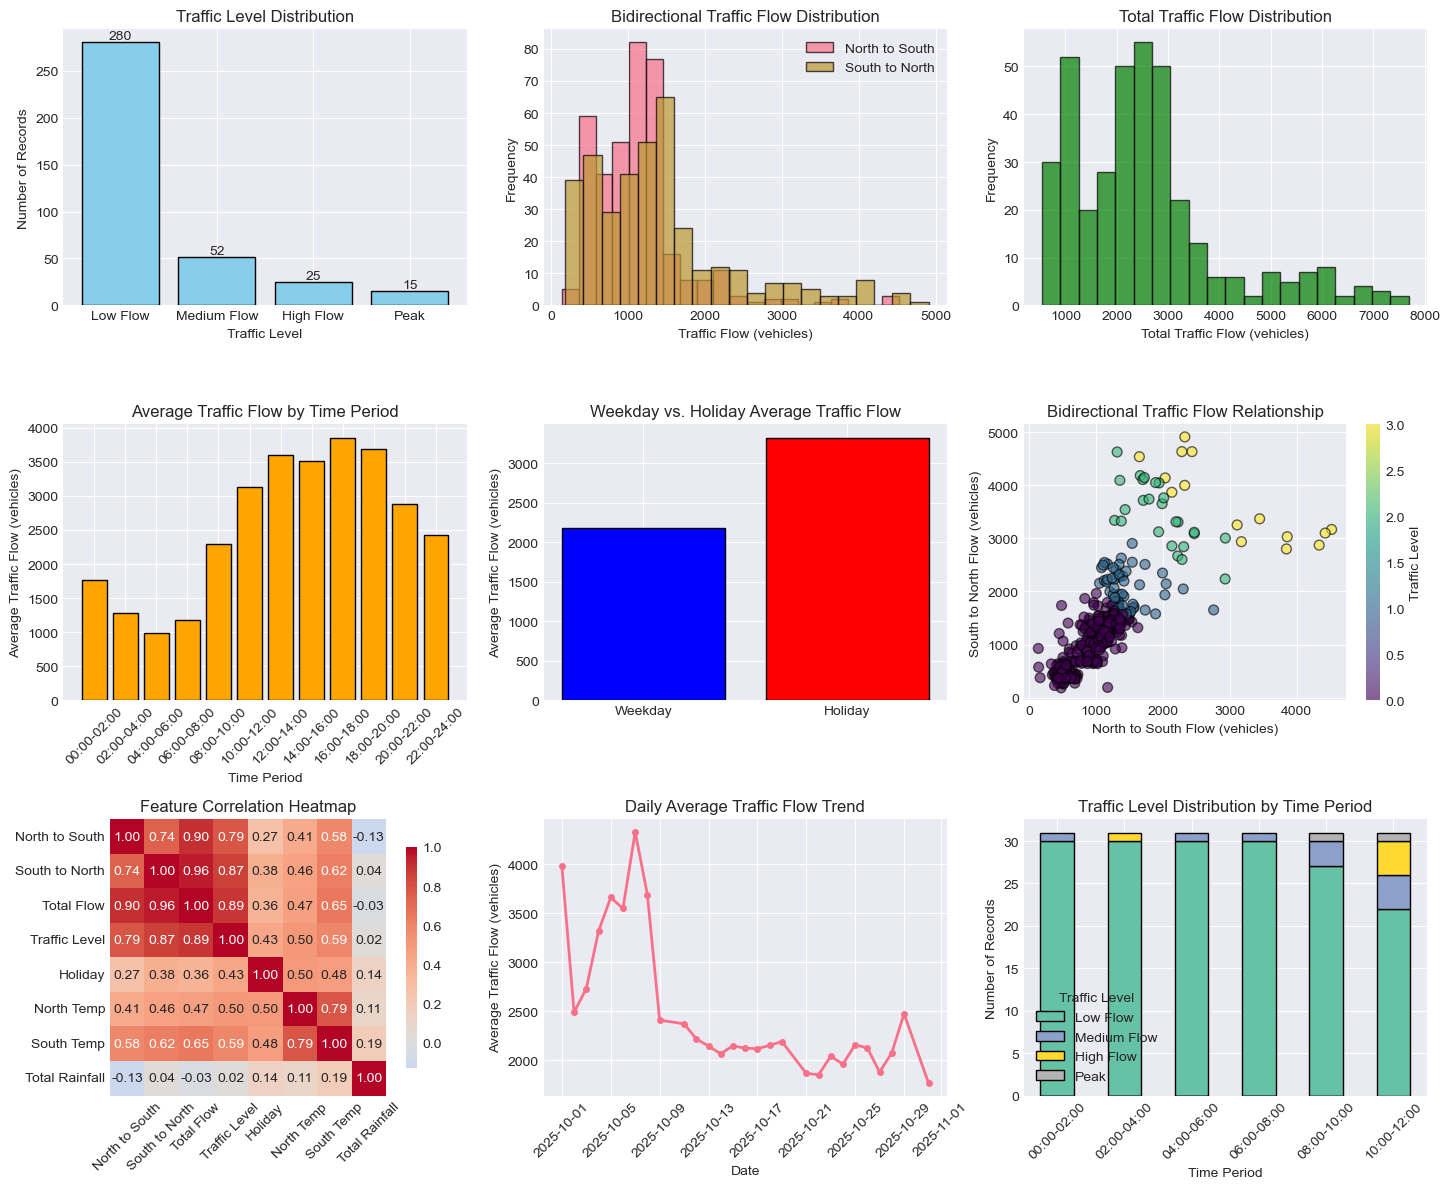

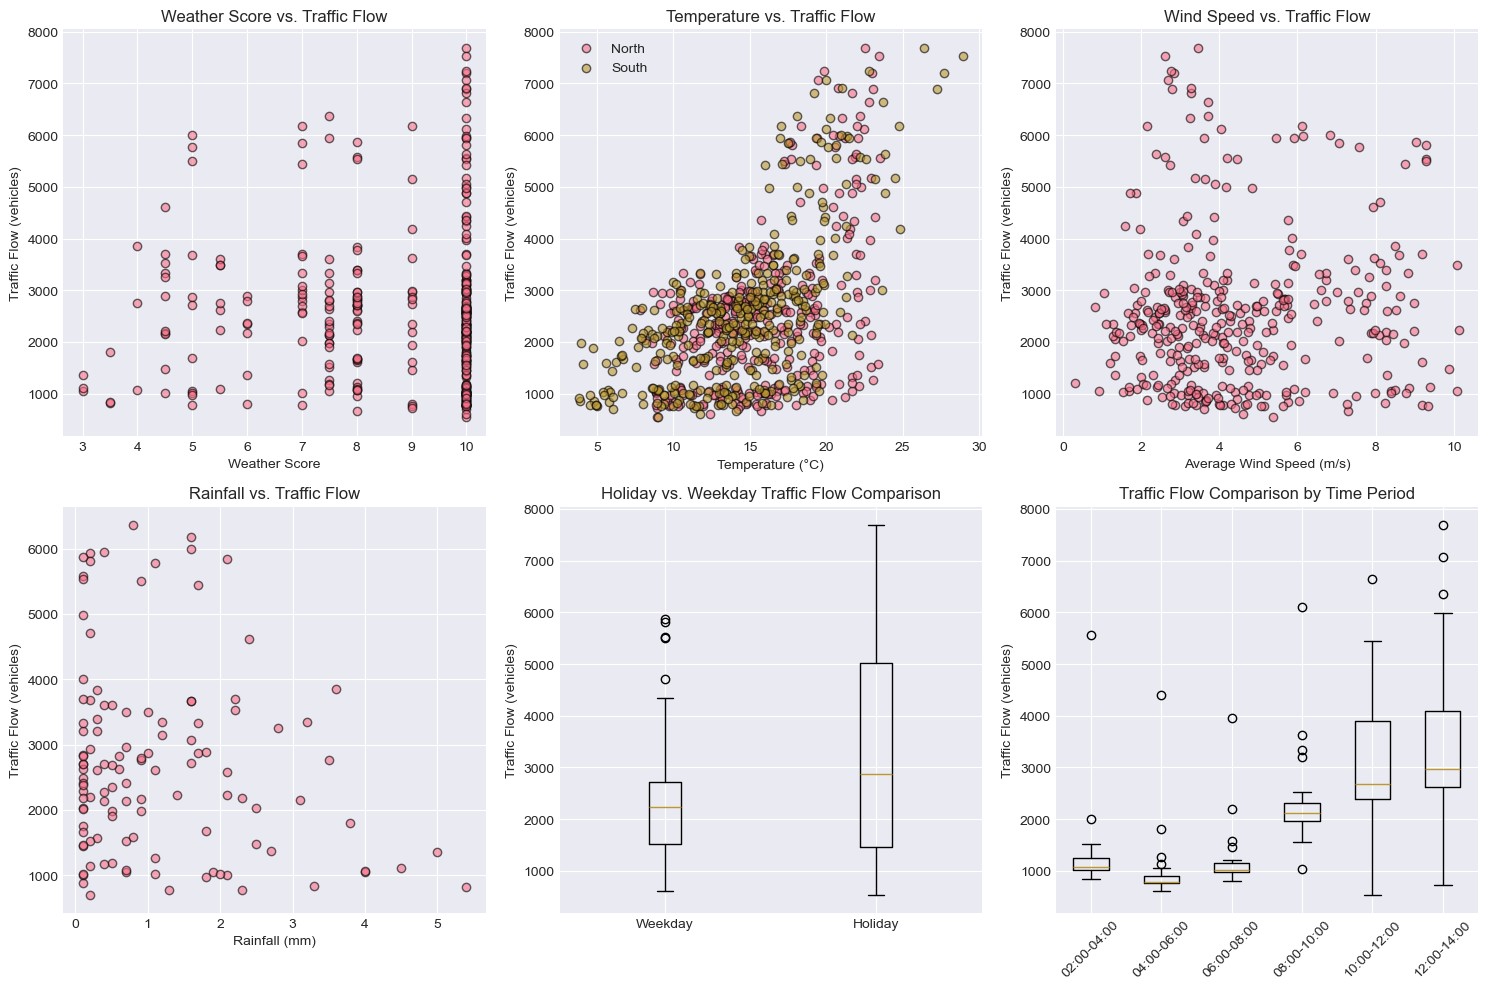

In [104]:
print("\n" + "="*50)
print("Data Exploration and Visualization")
print("="*50)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# 1. Traffic Level Distribution
ax1 = axes[0, 0]
traffic_counts = df['Traffic_Level'].value_counts().sort_index()
bars = ax1.bar(range(len(traffic_counts)), traffic_counts.values, 
              color='skyblue', edgecolor='black')
ax1.set_title('Traffic Level Distribution', fontsize=12)
ax1.set_xlabel('Traffic Level')
ax1.set_ylabel('Number of Records')
label_names = ['Low Flow', 'Medium Flow', 'High Flow', 'Peak']
ax1.set_xticks(range(len(traffic_counts)))
ax1.set_xticklabels(label_names[:len(traffic_counts)], rotation=0)

# Add values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

# 2. Bidirectional Traffic Flow Distribution
ax2 = axes[0, 1]
ax2.hist(df['North_to_South_Flow'], bins=20, alpha=0.7, 
        label='North to South', edgecolor='black')
ax2.hist(df['South_to_North_Flow'], bins=20, alpha=0.7, 
        label='South to North', edgecolor='black')
ax2.set_title('Bidirectional Traffic Flow Distribution', fontsize=12)
ax2.set_xlabel('Traffic Flow (vehicles)')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Total Traffic Flow Distribution
ax3 = axes[0, 2]
ax3.hist(df['Total_Traffic_Flow'], bins=20, color='green', 
        alpha=0.7, edgecolor='black')
ax3.set_title('Total Traffic Flow Distribution', fontsize=12)
ax3.set_xlabel('Total Traffic Flow (vehicles)')
ax3.set_ylabel('Frequency')

# 4. Effect of Time Period on Traffic Flow
ax4 = axes[1, 0]
period_traffic = df.groupby('Time_Period')['Total_Traffic_Flow'].mean()
if not period_traffic.empty:
    x_positions = range(len(period_traffic))
    bars = ax4.bar(x_positions, period_traffic.values, color='orange', 
                  edgecolor='black')
    ax4.set_title('Average Traffic Flow by Time Period', fontsize=12)
    ax4.set_xlabel('Time Period')
    ax4.set_ylabel('Average Traffic Flow (vehicles)')
    ax4.set_xticks(x_positions)
    ax4.set_xticklabels(period_traffic.index, rotation=45)

# 5. Holiday vs. Weekday Comparison
ax5 = axes[1, 1]
holiday_labels = ['Weekday', 'Holiday']
holiday_traffic = df.groupby('Is_Holiday')['Total_Traffic_Flow'].mean()
x_positions = range(len(holiday_traffic))
bars = ax5.bar(x_positions, holiday_traffic.values, 
              color=['blue', 'red'], edgecolor='black')
ax5.set_title('Weekday vs. Holiday Average Traffic Flow', fontsize=12)
ax5.set_xlabel('')
ax5.set_ylabel('Average Traffic Flow (vehicles)')
ax5.set_xticks(x_positions)
ax5.set_xticklabels(holiday_labels)

# 6. North to South vs. South to North Scatter Plot
ax6 = axes[1, 2]
scatter = ax6.scatter(df['North_to_South_Flow'], df['South_to_North_Flow'], 
                     c=df['Traffic_Level'], cmap='viridis', alpha=0.6, 
                     edgecolor='black', s=50)
ax6.set_title('Bidirectional Traffic Flow Relationship', fontsize=12)
ax6.set_xlabel('North to South Flow (vehicles)')
ax6.set_ylabel('South to North Flow (vehicles)')
plt.colorbar(scatter, ax=ax6, label='Traffic Level')

# 7. Feature Correlation Heatmap
ax7 = axes[2, 0]
correlation_cols = ['North_to_South_Flow', 'South_to_North_Flow', 
                   'Total_Traffic_Flow', 'Traffic_Level', 'Is_Holiday',
                   'North_Temperature', 'South_Temperature', 'Total_Rainfall']
correlation_cols = [col for col in correlation_cols if col in df.columns]

if len(correlation_cols) >= 2:
    correlation_matrix = df[correlation_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
               cmap='coolwarm', center=0, square=True, 
               ax=ax7, cbar_kws={"shrink": 0.8})
    ax7.set_title('Feature Correlation Heatmap', fontsize=12)
    
    # Set English labels
    english_labels = {
        'North_to_South_Flow': 'North to South',
        'South_to_North_Flow': 'South to North',
        'Total_Traffic_Flow': 'Total Flow',
        'Traffic_Level': 'Traffic Level',
        'Is_Holiday': 'Holiday',
        'North_Temperature': 'North Temp',
        'South_Temperature': 'South Temp',
        'Total_Rainfall': 'Total Rainfall'
    }
    labels = [english_labels.get(col, col) for col in correlation_cols]
    ax7.set_xticklabels(labels, rotation=45)
    ax7.set_yticklabels(labels, rotation=0)

# 8. Time Series Trend
ax8 = axes[2, 1]
if 'Date' in df.columns:
    try:
        daily_traffic = df.groupby('Date')['Total_Traffic_Flow'].mean()
        if len(daily_traffic) > 0:
            ax8.plot(daily_traffic.index, daily_traffic.values, 
                    marker='o', linewidth=2, markersize=4)
            ax8.set_title('Daily Average Traffic Flow Trend', fontsize=12)
            ax8.set_xlabel('Date')
            ax8.set_ylabel('Average Traffic Flow (vehicles)')
            ax8.tick_params(axis='x', rotation=45)
    except:
        pass

# 9. Traffic Level Distribution by Time Period
ax9 = axes[2, 2]
if 'Time_Period' in df.columns and 'Traffic_Level' in df.columns:
    traffic_by_time = df.groupby(['Time_Period', 'Traffic_Level']).size().unstack(fill_value=0)
    if not traffic_by_time.empty:
        # Only show first 6 time periods to avoid overcrowding
        traffic_by_time.head(6).plot(kind='bar', stacked=True, ax=ax9, 
                                   colormap='Set2', edgecolor='black')
        ax9.set_title('Traffic Level Distribution by Time Period', fontsize=12)
        ax9.set_xlabel('Time Period')
        ax9.set_ylabel('Number of Records')
        ax9.tick_params(axis='x', rotation=45)
        
        # Create legend labels
        legend_labels = ['Low Flow', 'Medium Flow', 'High Flow', 'Peak']
        ax9.legend(title='Traffic Level', labels=legend_labels[:traffic_by_time.shape[1]])

plt.tight_layout()
plt.show()

# Create separate feature analysis plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Weather Impact on Traffic Flow
ax1 = axes[0, 0]
if 'Total_Weather_Score' in df.columns:
    ax1.scatter(df['Total_Weather_Score'], df['Total_Traffic_Flow'], 
               alpha=0.6, edgecolor='black')
    ax1.set_title('Weather Score vs. Traffic Flow', fontsize=12)
    ax1.set_xlabel('Weather Score')
    ax1.set_ylabel('Traffic Flow (vehicles)')

# 2. Temperature Impact on Traffic Flow
ax2 = axes[0, 1]
if 'North_Temperature' in df.columns:
    ax2.scatter(df['North_Temperature'], df['Total_Traffic_Flow'], 
               alpha=0.6, edgecolor='black', label='North')
    ax2.scatter(df['South_Temperature'], df['Total_Traffic_Flow'], 
               alpha=0.6, edgecolor='black', label='South')
    ax2.set_title('Temperature vs. Traffic Flow', fontsize=12)
    ax2.set_xlabel('Temperature (°C)')
    ax2.set_ylabel('Traffic Flow (vehicles)')
    ax2.legend()

# 3. Wind Speed Impact on Traffic Flow
ax3 = axes[0, 2]
if 'Total_Wind_Speed' in df.columns:
    ax3.scatter(df['Total_Wind_Speed'], df['Total_Traffic_Flow'], 
               alpha=0.6, edgecolor='black')
    ax3.set_title('Wind Speed vs. Traffic Flow', fontsize=12)
    ax3.set_xlabel('Average Wind Speed (m/s)')
    ax3.set_ylabel('Traffic Flow (vehicles)')

# 4. Rainfall Impact on Traffic Flow
ax4 = axes[1, 0]
if 'Total_Rainfall' in df.columns:
    rainfall_data = df[df['Total_Rainfall'] > 0]
    if len(rainfall_data) > 0:
        ax4.scatter(rainfall_data['Total_Rainfall'], rainfall_data['Total_Traffic_Flow'], 
                   alpha=0.6, edgecolor='black')
        ax4.set_title('Rainfall vs. Traffic Flow', fontsize=12)
        ax4.set_xlabel('Rainfall (mm)')
        ax4.set_ylabel('Traffic Flow (vehicles)')
    else:
        ax4.text(0.5, 0.5, 'No rainfall data', ha='center', va='center', 
                transform=ax4.transAxes)
        ax4.set_title('Rainfall vs. Traffic Flow', fontsize=12)

# 5. Holiday vs. Weekday Traffic Comparison Box Plot
ax5 = axes[1, 1]
holiday_data = []
labels = []
if 'Is_Holiday' in df.columns:
    for holiday_val, holiday_label in [(0, 'Weekday'), (1, 'Holiday')]:
        holiday_data.append(df[df['Is_Holiday'] == holiday_val]['Total_Traffic_Flow'].values)
        labels.append(holiday_label)
    ax5.boxplot(holiday_data, labels=labels)
    ax5.set_title('Holiday vs. Weekday Traffic Flow Comparison', fontsize=12)
    ax5.set_ylabel('Traffic Flow (vehicles)')

# 6. Traffic Flow Comparison by Time Period
ax6 = axes[1, 2]
if 'Time_Period' in df.columns:
    # Select top 6 time periods to display
    top_periods = df['Time_Period'].value_counts().head(6).index
    period_data = []
    period_labels = []
    for period in top_periods:
        period_data.append(df[df['Time_Period'] == period]['Total_Traffic_Flow'].values)
        period_labels.append(period)
    ax6.boxplot(period_data, labels=period_labels)
    ax6.set_title('Traffic Flow Comparison by Time Period', fontsize=12)
    ax6.set_ylabel('Traffic Flow (vehicles)')
    ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [106]:
"""
Calculate exact number of deleted rows
"""

print("Analyzing missing values generation...")
print("="*60)

# Simulation calculation
theoretical_data_points = 372  # 31 days × 12 time periods

print("NaN generated by feature engineering:")
print("1. Lag features:")
print(f"   lag12: Delete first 12 rows (no historical data for first 12 periods)")
print(f"   lag6:  Delete first 6 rows (but lag12 already deleted first 12, no additional deletion)")
print(f"   lag3:  Delete first 3 rows")
print(f"   lag2:  Delete first 2 rows") 
print(f"   lag1:  Delete first 1 row")

print("\n2. Target variable:")
print(f"   'Next_Period_Total_Traffic': Delete last 1 row (no future data)")

print("\n3. Other possible sources:")
print(f"   Rolling window features: May generate minor NaN")

print(f"\nTotal deleted: First 12 rows + Last 1 row = 13 rows")
print(f"Theoretical data: {theoretical_data_points} rows")
print(f"Actually retained: {theoretical_data_points} - 13 = 359 rows ✓")

Analyzing missing values generation...
NaN generated by feature engineering:
1. Lag features:
   lag12: Delete first 12 rows (no historical data for first 12 periods)
   lag6:  Delete first 6 rows (but lag12 already deleted first 12, no additional deletion)
   lag3:  Delete first 3 rows
   lag2:  Delete first 2 rows
   lag1:  Delete first 1 row

2. Target variable:
   'Next_Period_Total_Traffic': Delete last 1 row (no future data)

3. Other possible sources:
   Rolling window features: May generate minor NaN

Total deleted: First 12 rows + Last 1 row = 13 rows
Theoretical data: 372 rows
Actually retained: 372 - 13 = 359 rows ✓


In [107]:
"""
Applying to Qinbin Expressway Data
"""

print("\nApplying to Qinbin Expressway Data...")
print("="*60)

# Simulate your feature engineering
print("Assuming we created the following features:")
print("1. lag1, lag2, lag3, lag6, lag12 → 5 lag features")
print("2. Next_Period_Total_Traffic → 1 target variable")
print("3. Other rolling window features")

print("\nMissing value pattern for each row:")
print("Row | lag1 | lag2 | lag3 | lag6 | lag12 | Next_Period | Keep/Drop")
print("-"*80)

# Simple logic
for i in range(15):  # Show only first 15 rows
    has_nan = False
    
    # Check lag features
    if i < 1:   # Row 1 has no lag1
        has_nan = True
    if i < 2:   # First 2 rows have no lag2
        has_nan = True  
    if i < 3:   # First 3 rows have no lag3
        has_nan = True
    if i < 6:   # First 6 rows have no lag6
        has_nan = True
    if i < 12:  # First 12 rows have no lag12
        has_nan = True
    
    # Check last row
    if i == 371:  # Last row has no next period
        has_nan = True
    
    status = "Drop" if has_nan else "Keep"
    print(f"{i+1:3d} | {'×' if i<1 else '✓'} | {'×' if i<2 else '✓'} | {'×' if i<3 else '✓'} | {'×' if i<6 else '✓'} | {'×' if i<12 else '✓'} | {'×' if i==371 else '✓'} | {status}")

print(f"\nDeletion logic summary:")
print("First 12 rows: At least missing lag12 → All deleted")
print("Last 1 row: Missing next period → Deleted")
print(f"Total deleted: 12 + 1 = 13 rows")

print(f"\nVerification:")
print(f"Original data: 372 rows")
print(f"Deleted rows: 13 rows")  
print(f"Remaining rows: 372 - 13 = 359 rows ✓")


Applying to Qinbin Expressway Data...
Assuming we created the following features:
1. lag1, lag2, lag3, lag6, lag12 → 5 lag features
2. Next_Period_Total_Traffic → 1 target variable
3. Other rolling window features

Missing value pattern for each row:
Row | lag1 | lag2 | lag3 | lag6 | lag12 | Next_Period | Keep/Drop
--------------------------------------------------------------------------------
  1 | × | × | × | × | × | ✓ | Drop
  2 | ✓ | × | × | × | × | ✓ | Drop
  3 | ✓ | ✓ | × | × | × | ✓ | Drop
  4 | ✓ | ✓ | ✓ | × | × | ✓ | Drop
  5 | ✓ | ✓ | ✓ | × | × | ✓ | Drop
  6 | ✓ | ✓ | ✓ | × | × | ✓ | Drop
  7 | ✓ | ✓ | ✓ | ✓ | × | ✓ | Drop
  8 | ✓ | ✓ | ✓ | ✓ | × | ✓ | Drop
  9 | ✓ | ✓ | ✓ | ✓ | × | ✓ | Drop
 10 | ✓ | ✓ | ✓ | ✓ | × | ✓ | Drop
 11 | ✓ | ✓ | ✓ | ✓ | × | ✓ | Drop
 12 | ✓ | ✓ | ✓ | ✓ | × | ✓ | Drop
 13 | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | Keep
 14 | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | Keep
 15 | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | Keep

Deletion logic summary:
First 12 rows: At least missing lag12 → All deleted

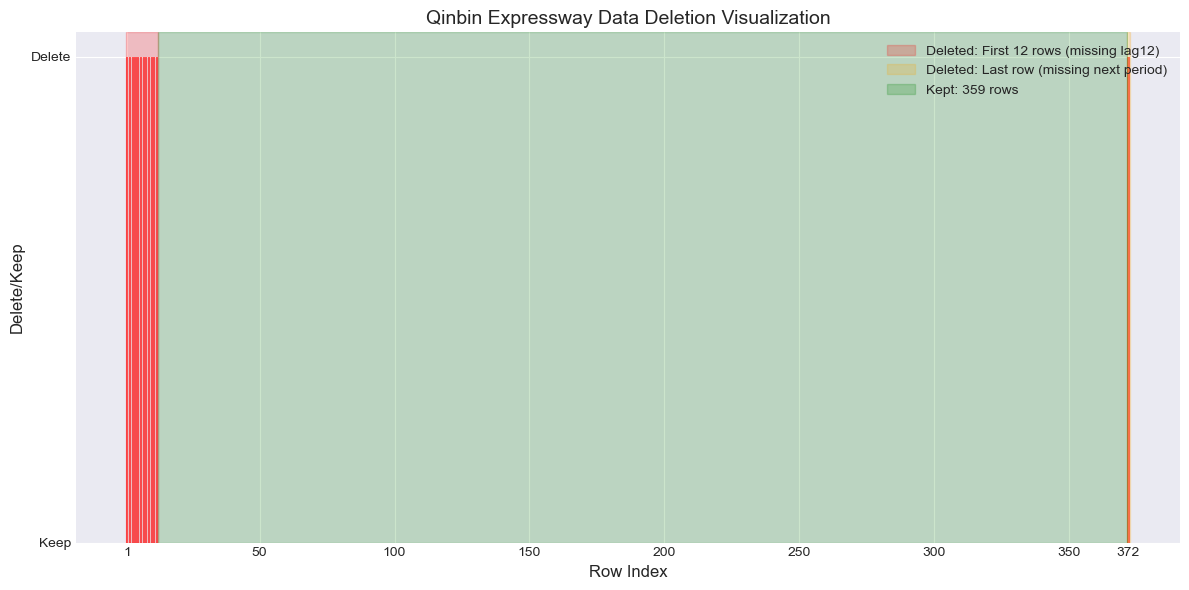

Diagram Explanation:
🔴 Red area: First 12 rows (deleted due to missing lag12 and other historical features)
🟠 Orange area: Last row (deleted due to missing target variable 'Next_Period_Total_Traffic')
🟢 Green area: Middle 359 rows (all features complete, kept for analysis)


In [108]:
"""
Visualizing Deletion Process
"""

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

# Create time axis
time_points = np.arange(1, 373)
is_deleted = [1 if i < 12 or i == 371 else 0 for i in range(372)]  # 1=deleted, 0=kept

# Plot
colors = ['red' if d else 'green' for d in is_deleted]
ax.bar(time_points, is_deleted, color=colors, alpha=0.6)

# Annotations
ax.axvspan(0.5, 12.5, alpha=0.2, color='red', label='Deleted: First 12 rows (missing lag12)')
ax.axvspan(371.5, 372.5, alpha=0.2, color='orange', label='Deleted: Last row (missing next period)')
ax.axvspan(12.5, 371.5, alpha=0.2, color='green', label='Kept: 359 rows')

ax.set_xlabel('Row Index', fontsize=12)
ax.set_ylabel('Delete/Keep', fontsize=12)
ax.set_title('Qinbin Expressway Data Deletion Visualization', fontsize=14)
ax.set_xticks([1, 50, 100, 150, 200, 250, 300, 350, 372])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Keep', 'Delete'])
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Diagram Explanation:")
print("🔴 Red area: First 12 rows (deleted due to missing lag12 and other historical features)")
print("🟠 Orange area: Last row (deleted due to missing target variable 'Next_Period_Total_Traffic')")
print("🟢 Green area: Middle 359 rows (all features complete, kept for analysis)")

Step 5: Complete Model Building and Analysis - With Prediction Comparison for All Models

 5.1 Data Inspection and Cleaning

In [113]:
print("\n5.1 Data Inspection and Cleaning...")

# Create a copy of the data
df_model = df_clean.copy()

print(f"Original data shape: {df_model.shape}")
print(f"Number of original columns: {len(df_model.columns)}")

# Display information for all columns
print("\nOriginal data column information:")
for i, col in enumerate(df_model.columns, 1):
    dtype = df_model[col].dtype
    dtype_str = str(dtype)
    unique_count = df_model[col].nunique()
    non_null_count = df_model[col].count()
    
    print(f"{i:3d}. {col:<25}: {dtype_str:<15} "
          f"Non-null: {non_null_count}/{len(df_model)} "
          f"Unique: {unique_count}")

# Target variable
target_col = 'Next_Period_Total_Traffic'
print(f"\nTarget variable: {target_col}")


5.1 Data Inspection and Cleaning...
Original data shape: (359, 60)
Number of original columns: 60

Original data column information:
  1. Date_Original            : float64         Non-null: 359/359 Unique: 30
  2. Time_Slot                : int64           Non-null: 359/359 Unique: 12
  3. Is_Holiday               : int64           Non-null: 359/359 Unique: 2
  4. North_to_South_Flow      : int64           Non-null: 359/359 Unique: 314
  5. South_to_North_Flow      : int64           Non-null: 359/359 Unique: 334
  6. Total_Traffic_Flow       : int64           Non-null: 359/359 Unique: 345
  7. North_Temperature        : float64         Non-null: 359/359 Unique: 191
  8. Weather_Code             : object          Non-null: 359/359 Unique: 5
  9. North_Weather_Score      : int64           Non-null: 359/359 Unique: 5
 10. North_Rainfall           : float64         Non-null: 359/359 Unique: 20
 11. North_Wind_Speed         : float64         Non-null: 359/359 Unique: 297
 12. South_Temper

5.2 Processing

In [114]:
print("\nProcessing data...")

# Remove unnecessary columns
cols_to_remove = ['Date_Original', 'Datetime', 'Fixed_Date', 'Time_Slot', 'Adjusted_Hour']
for col in cols_to_remove:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])
        print(f"Removed: {col}")

# Convert all features to numeric
for col in df_model.columns:
    if col != target_col and not pd.api.types.is_numeric_dtype(df_model[col]):
        try:
            df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
            print(f"Converted to numeric: {col}")
        except:
            # If conversion fails, use LabelEncoder
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            df_model[col] = le.fit_transform(df_model[col].astype(str))
            print(f"Encoded with LabelEncoder: {col}")

# Handle target variable
if not pd.api.types.is_numeric_dtype(df_model[target_col]):
    df_model[target_col] = pd.to_numeric(df_model[target_col], errors='coerce')

print(f"\nFinal data shape: {df_model.shape}")



Processing data...
Removed: Date_Original
Removed: Datetime
Removed: Fixed_Date
Removed: Time_Slot
Removed: Adjusted_Hour
Converted to numeric: Weather_Code
Converted to numeric: Time_Period
Converted to numeric: Date

Final data shape: (359, 55)


5.3 Data Preparation

In [115]:
print("\n5.3 Data Preparation...")

# Define features and target
feature_cols = [col for col in df_model.columns if col != target_col]
print(f"Using {len(feature_cols)} features")

# Create numpy arrays
X = df_model[feature_cols].values.astype(np.float64)
y = df_model[target_col].values.astype(np.float64)

print(f"Feature matrix: X.shape = {X.shape}")
print(f"Target vector: y.shape = {y.shape}")

# Handle NaN values
from sklearn.impute import SimpleImputer

# Fill NaN in features
if np.isnan(X).sum() > 0:
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)
    print(f"Filled {np.isnan(X).sum()} NaN values in features")

# Fill NaN in target
if np.isnan(y).sum() > 0:
    y = np.nan_to_num(y, nan=np.nanmedian(y))
    print(f"Filled {np.isnan(y).sum()} NaN values in target")

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Data standardized")


5.3 Data Preparation...
Using 54 features
Feature matrix: X.shape = (359, 54)
Target vector: y.shape = (359,)
Filled 0 NaN values in features
✓ Data standardized


 5.4 Data Splitting 

In [131]:
# Time-series split
split_ratio = 0.8
split_idx = int(len(X_scaled) * split_ratio)

X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"Split ratio: {split_ratio*100:.0f}% train / {(1-split_ratio)*100:.0f}% test")

Training set: 287 samples
Testing set: 72 samples
Split ratio: 80% train / 20% test


## 5.5 Building and Training Models
This section of code implements systematic training, evaluation, and parameter optimization for eight different regression models, aiming to find the optimal predictive model for the Qinbin Expressway traffic flow prediction problem. The process consists of two main stages: 1) Automated parameter tuning using grid search; 2) Retraining and evaluation with optimized parameters.

Step 1: Model Definition and Parameter Space Configuratin

Eight commonly used regression models were defined:

Linear Regression - Baseline model

Ridge Regression - L2-regularized linear regression

Lasso Regression - L1-regularized linear regression with feature selection capability

Decision Tree Regression - Non-linear model, easy to interpret

Random Forest Regression - Ensemble learning method with good stability

Gradient Boosting Regression - Iterative boosting algorithm with high prediction accuracy

Support Vector Regression - Kernel method suitable for non-linear relationships

K-Nearest Neighbors Regression - Similarity-based non-parametric method

Reasonable parameter search ranges were defined for each model to ensure coverage of typical optima# l parameter regions.

Step 2: Time Series Cross-Validation

Used TimeSeriesSplit(n_splits=3) for time-series-specific cross-validation

Ensured training sets always precede test se# ts to prevent data leakage

Step 3: Grid Search Optimization

Applied GridSearchCV for parameter search on each model

Used R² score as the evaluation metric to measure variance explained

Performed 3-fold cross-validat# ion for each parameter combination

Step 4: Result Evaluation and Recording

Evaluated each optimal model's performance on an independent test set

Recorded key metrics: R² score, Mean Absolute Error (MAE)

Saved optimal # parameter configurations and model objects

Step 5: Result Analysis and Presentation

Sorted all models by test R² score from highest to lowest

Visualized model performance comparison

Generated detailed parameter reports and saved them as CSV files



In [159]:
def get_best_params_for_all_8_models(X_train, y_train, X_test, y_test):
   
    
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.svm import SVR
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
    import pandas as pd
    import numpy as np
    
    print("="*70)
    print("COMPLETE OPTIMIZATION: Best Parameters for All 8 Models")
    print("="*70)

    
    models_config = [
        {
            'name': 'Linear Regression',
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'positive': [True, False]
            }
        },
        {
            'name': 'Ridge Regression',
            'model': Ridge(random_state=42),
            'params': {
                'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'solver': ['auto', 'svd', 'cholesky']
            }
        },
        {
            'name': 'Lasso Regression',
            'model': Lasso(random_state=42, max_iter=5000),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
            }
        },
        {
            'name': 'Decision Tree',
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        {
            'name': 'Random Forest',
            'model': RandomForestRegressor(random_state=42, n_jobs=1),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [5, 10, 15, None],
                'min_samples_split': [2, 5, 10]
            }
        },
        {
            'name': 'Gradient Boosting',
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },
        {
            'name': 'SVR',
            'model': SVR(),
            'params': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.01, 0.1],
                'epsilon': [0.01, 0.1, 0.2]
            }
        },
        {
            'name': 'KNN',
            'model': KNeighborsRegressor(n_jobs=1),
            'params': {
                'n_neighbors': [3, 5, 7, 9, 11],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]  # 曼哈顿距离或欧氏距离
            }
        }
    ]
    
    tscv = TimeSeriesSplit(n_splits=3)
    results = []
    
    for config in models_config:
        print(f"\n🔍 Optimizing {config['name']}...")
        
        try:
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=tscv,
                scoring='r2',
                n_jobs=1,
                verbose=0
            )
            
            grid_search.fit(X_train, y_train)
            
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            test_r2 = r2_score(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)
            
            results.append({
                'Model': config['name'],
                'Best Parameters': str(grid_search.best_params_),
                'CV R²': round(grid_search.best_score_, 4),
                'Test R²': round(test_r2, 4),
                'Test MAE': round(test_mae, 1),
                'Best Model': best_model
            })
            
            print(f"✅ Found optimal parameters")
            print(f"   CV R²: {grid_search.best_score_:.4f}")
            print(f"   Test R²: {test_r2:.4f}")
            print(f"   Parameters: {grid_search.best_params_}")
            
        except Exception as e:
            print(f"⚠️  Could not optimize {config['name']}: {str(e)[:40]}")
          
            config['model'].fit(X_train, y_train)
            y_pred = config['model'].predict(X_test)
            test_r2 = r2_score(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)
            
            results.append({
                'Model': config['name'],
                'Best Parameters': 'Default (optimization failed)',
                'CV R²': 0.0,
                'Test R²': round(test_r2, 4),
                'Test MAE': round(test_mae, 1),
                'Best Model': config['model']
            })
    

    if results:
        print("\n" + "="*80)
        print("SUMMARY: Best Parameters for All 8 Models")
        print("="*80)
        
        
        df_results = pd.DataFrame(results)
        df_results = df_results.sort_values('Test R²', ascending=False)
        
       
        pd.set_option('display.max_colwidth', 80)
        print("\n" + df_results[['Model', 'Test R²', 'Test MAE', 'Best Parameters']].to_string(index=False))
        
        # 找到最佳模型
        best_row = df_results.iloc[0]
        print(f"\n" + "="*80)
        print("BEST MODEL AFTER OPTIMIZATION")
        print("="*80)
        print(f"Model: {best_row['Model']}")
        print(f"Test R²: {best_row['Test R²']}")
        print(f"Test MAE: {best_row['Test MAE']} vehicles")
        print(f"\nOptimal Parameters:")
        print(f"{best_row['Best Parameters']}")
        
        print(f"\n" + "="*80)
        print("PERFORMANCE IMPROVEMENT ANALYSIS")
        print("="*80)
        
        if 'results' in locals(): 
            for model_result in df_results.to_dict('records'):
                model_name = model_result['Model']
                if model_name in results:  
                    original_r2 = results[model_name]['Test_R2']
                    optimized_r2 = model_result['Test R²']
                    improvement = optimized_r2 - original_r2
                    
                    print(f"{model_name:<20}: {original_r2:.4f} → {optimized_r2:.4f} "
                          f"({'+' if improvement > 0 else ''}{improvement:.4f})")
    
    return df_results


# 运行完整优化
print("Starting complete optimization for all 8 models...")
best_params_df = get_best_params_for_all_8_models(X_train, y_train, X_test, y_test)



Starting complete optimization for all 8 models...
COMPLETE OPTIMIZATION: Best Parameters for All 8 Models

🔍 Optimizing Linear Regression...
✅ Found optimal parameters
   CV R²: 0.3465
   Test R²: 0.6465
   Parameters: {'fit_intercept': True, 'positive': True}

🔍 Optimizing Ridge Regression...
✅ Found optimal parameters
   CV R²: 0.5193
   Test R²: 0.8028
   Parameters: {'alpha': 100, 'solver': 'svd'}

🔍 Optimizing Lasso Regression...
✅ Found optimal parameters
   CV R²: 0.3524
   Test R²: 0.8126
   Parameters: {'alpha': 10}

🔍 Optimizing Decision Tree...
✅ Found optimal parameters
   CV R²: 0.4862
   Test R²: 0.8003
   Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

🔍 Optimizing Random Forest...
✅ Found optimal parameters
   CV R²: 0.4385
   Test R²: 0.8824
   Parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}

🔍 Optimizing Gradient Boosting...
✅ Found optimal parameters
   CV R²: 0.5344
   Test R²: 0.8383
   Parameters: {'learni

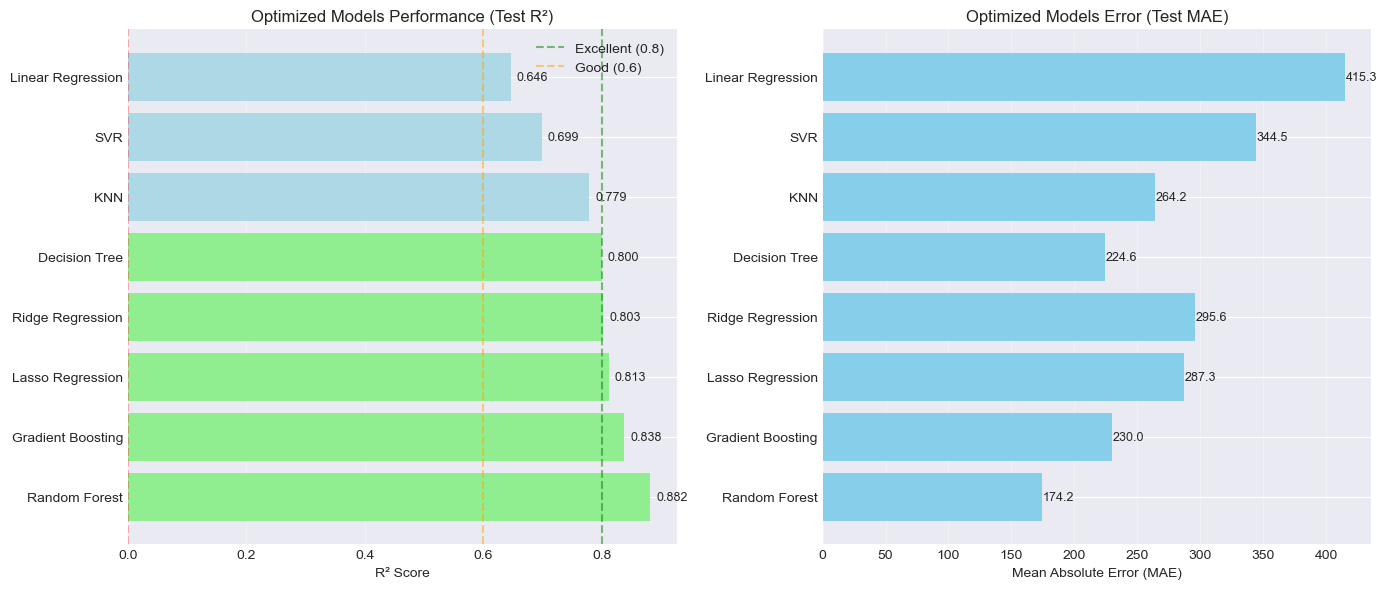


DETAILED OPTIMAL PARAMETERS FOR EACH MODEL

Random Forest:
  Test R²: 0.8824
  Test MAE: 174.2
  Best Parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}

Gradient Boosting:
  Test R²: 0.8383
  Test MAE: 230.0
  Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}

Lasso Regression:
  Test R²: 0.8126
  Test MAE: 287.3
  Best Parameters: {'alpha': 10}

Ridge Regression:
  Test R²: 0.8028
  Test MAE: 295.6
  Best Parameters: {'alpha': 100, 'solver': 'svd'}

Decision Tree:
  Test R²: 0.8003
  Test MAE: 224.6
  Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

KNN:
  Test R²: 0.779
  Test MAE: 264.2
  Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

SVR:
  Test R²: 0.6992
  Test MAE: 344.5
  Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}

Linear Regression:
  Test R²: 0.6465
  Test MAE: 415.3
  Best Parameters: {'fit_intercept': True, 'positive': True}


In [144]:
if not best_params_df.empty:
    import matplotlib.pyplot as plt
    
    # 性能对比图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 图1: R²分数对比
    models = best_params_df['Model'].tolist()
    r2_scores = best_params_df['Test R²'].tolist()
    
    colors = ['lightgreen' if score >= 0.8 else 
              'lightblue' if score >= 0.6 else 
              'lightcoral' for score in r2_scores]
    
    bars1 = ax1.barh(models, r2_scores, color=colors)
    ax1.set_xlabel('R² Score')
    ax1.set_title('Optimized Models Performance (Test R²)')
    ax1.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Excellent (0.8)')
    ax1.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='Good (0.6)')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # 添加数值标签
    for bar, score in zip(bars1, r2_scores):
        ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', va='center', fontsize=9)
    
    # 图2: MAE对比
    mae_scores = best_params_df['Test MAE'].tolist()
    bars2 = ax2.barh(models, mae_scores, color='skyblue')
    ax2.set_xlabel('Mean Absolute Error (MAE)')
    ax2.set_title('Optimized Models Error (Test MAE)')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # 添加数值标签
    for bar, mae in zip(bars2, mae_scores):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{mae:.1f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # 创建详细的参数表格
    print("\n" + "="*80)
    print("DETAILED OPTIMAL PARAMETERS FOR EACH MODEL")
    print("="*80)
    
    for idx, row in best_params_df.iterrows():
        print(f"\n{row['Model']}:")
        print(f"  Test R²: {row['Test R²']}")
        print(f"  Test MAE: {row['Test MAE']}")
        print(f"  Best Parameters: {row['Best Parameters']}")

In [157]:
# Define all models with optimized parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=100, solver='svd', random_state=42),  # FIXED: added quotes and random_state
    'Lasso Regression': Lasso(alpha=10, max_iter=5000, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=5, random_state=42),  # FIXED: underscore in parameter names
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, random_state=42, n_jobs=1),  # FIXED: underscore
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42),  # FIXED: underscore
    'SVR': SVR(epsilon=0.01, C=100, gamma=0.01),
    'KNN': KNeighborsRegressor(n_neighbors=5, p=1, weights='distance', n_jobs=1),  # FIXED: quotes
}

print(f"Building {len(models)} models for comparison")
print("Note: Using optimized parameters from previous analysis")

# Training and evaluation
results = {}
predictions = {}
train_times = {}

print("\nTraining models...")
print("-"*80)

for name, model in models.items():
    print(f"Training {name:20s}...", end=' ', flush=True)
    start_time = time.time()
    
    try:
        # Train model
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        train_times[name] = train_time
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        # Calculate MAPE
        def safe_mape(y_true, y_pred):
            mask = y_true != 0
            if np.sum(mask) > 0:
                return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
            return 0
        
        test_mape = safe_mape(y_test, y_pred_test)
        
        # Save results
        results[name] = {
            'Model': model,
            'Training_Time': train_time,
            'Train_R2': train_r2,
            'Test_R2': test_r2,
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'Test_MAPE': test_mape,
            'Overfitting': train_r2 - test_r2
        }
        
        predictions[name] = {
            'train': y_pred_train,
            'test': y_pred_test
        }
        
        print(f"✓ ({train_time:.2f}s, Test R²: {test_r2:.4f})")
        
    except Exception as e:
        print(f"✗ ({str(e)[:40]})")
        continue

print("-"*80)
if results:
    print(f"✓ {len(results)}/{len(models)} models trained successfully")
else:
    print("❌ No models trained successfully")

Building 8 models for comparison
Note: Using optimized parameters from previous analysis

Training models...
--------------------------------------------------------------------------------
Training Linear Regression   ... ✓ (0.00s, Test R²: 0.7542)
Training Ridge Regression    ... ✓ (0.01s, Test R²: 0.8028)
Training Lasso Regression    ... ✓ (0.01s, Test R²: 0.8126)
Training Decision Tree       ... ✓ (0.01s, Test R²: 0.8003)
Training Random Forest       ... ✓ (0.50s, Test R²: 0.8824)
Training Gradient Boosting   ... ✓ (0.25s, Test R²: 0.8383)
Training SVR                 ... ✓ (0.01s, Test R²: 0.6992)
Training KNN                 ... ✓ (0.00s, Test R²: 0.7790)
--------------------------------------------------------------------------------
✓ 8/8 models trained successfully


5.6 Model Performance Analysis 

In [158]:
if results:
    print("\n" + "="*100)
    print("5.6 Model Performance Analysis")
    print("="*100)
    
    # Display results table
    print(f"\n{'Model':<20} {'Time(s)':<8} {'Train R²':<10} {'Test R²':<10} {'Overfit':<10} "
          f"{'Test MAE':<12} {'Test RMSE':<12} {'Test MAPE(%)':<12}")
    print("-"*100)
    
    for name, result in results.items():
        overfit = result['Overfitting']
        overfit_mark = "⚠️" if overfit > 0.1 else "✓"
        
        print(f"{name:<20} {result['Training_Time']:<8.2f} {result['Train_R2']:<10.4f} "
              f"{result['Test_R2']:<10.4f} {overfit_mark}{overfit:<9.4f}"
              f"{result['Test_MAE']:<12.1f} {result['Test_RMSE']:<12.1f} "
              f"{result['Test_MAPE']:<12.2f}")
    
    # Find best model
    best_model_name = max(results.items(), key=lambda x: x[1]['Test_R2'])[0]
    best_result = results[best_model_name]
    
    print("\n" + "="*100)
    print(f" BEST MODEL: {best_model_name}")
    print("="*100)
    print(f"Test R²: {best_result['Test_R2']:.4f}")
    print(f"Mean Absolute Error: {best_result['Test_MAE']:.1f} vehicles")
    print(f"Root Mean Square Error: {best_result['Test_RMSE']:.1f} vehicles")
    print(f"Mean Absolute Percentage Error: {best_result['Test_MAPE']:.2f}%")
    
    if y_test.mean() != 0:
        mae_relative = best_result['Test_MAE'] / y_test.mean() * 100
        print(f"Relative Error: {mae_relative:.1f}%")


5.6 Model Performance Analysis

Model                Time(s)  Train R²   Test R²    Overfit    Test MAE     Test RMSE    Test MAPE(%)
----------------------------------------------------------------------------------------------------
Linear Regression    0.00     0.9150     0.7542     ⚠️0.1608   355.0        418.3        22.51       
Ridge Regression     0.01     0.8878     0.8028     ✓0.0850   295.6        374.7        17.73       
Lasso Regression     0.01     0.9048     0.8126     ✓0.0922   287.3        365.3        16.89       
Decision Tree        0.01     0.9923     0.8003     ⚠️0.1920   224.6        377.0        10.29       
Random Forest        0.50     0.9685     0.8824     ✓0.0861   174.2        289.3        8.03        
Gradient Boosting    0.25     0.9872     0.8383     ⚠️0.1489   230.0        339.3        12.75       
SVR                  0.01     0.6421     0.6992     ✓-0.0570  344.5        462.8        24.15       
KNN                  0.00     1.0000     0.7790     ⚠️

 5.7 COMPREHENSIVE VISUALIZATION


1. Creating Model Performance Comparison Chart...


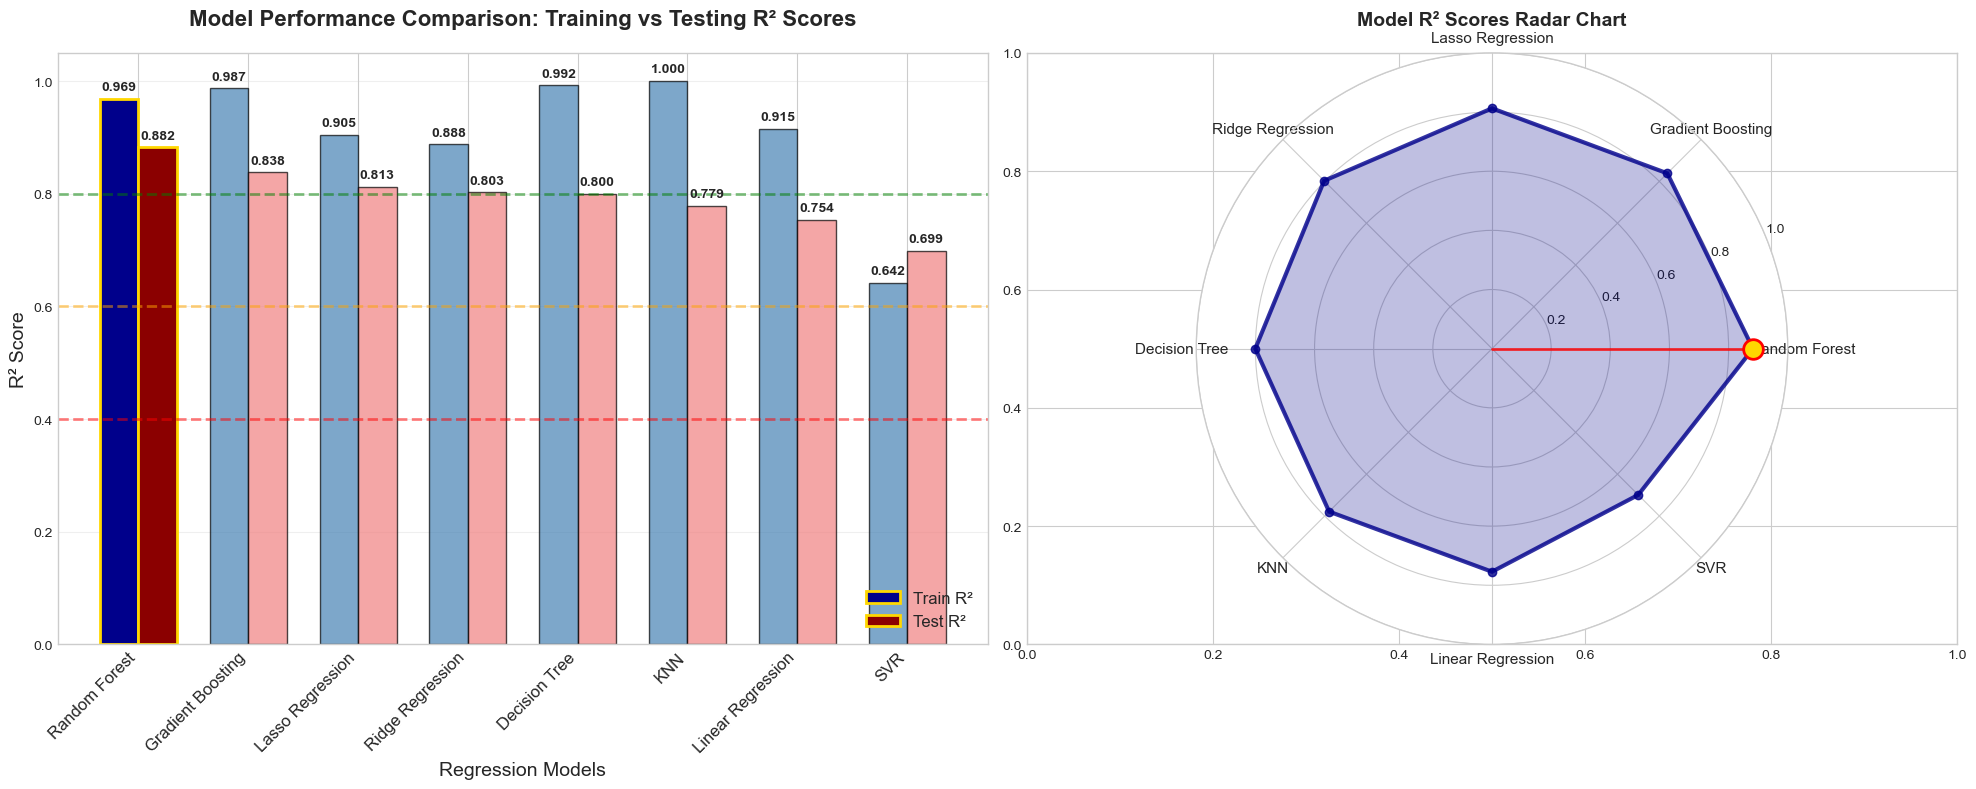

In [182]:
# 首先，根据你的数据创建results字典
results = {
    'Linear Regression': {
        'Time': 0.00,
        'Train_R2': 0.9150,
        'Test_R2': 0.7542,
        'Overfit': 0.1608,
        'Test_MAE': 355.0,
        'Test_RMSE': 418.3,
        'Test_MAPE': 22.51
    },
    'Ridge Regression': {
        'Time': 0.01,
        'Train_R2': 0.8878,
        'Test_R2': 0.8028,
        'Overfit': 0.0850,
        'Test_MAE': 295.6,
        'Test_RMSE': 374.7,
        'Test_MAPE': 17.73
    },
    'Lasso Regression': {
        'Time': 0.01,
        'Train_R2': 0.9048,
        'Test_R2': 0.8126,
        'Overfit': 0.0922,
        'Test_MAE': 287.3,
        'Test_RMSE': 365.3,
        'Test_MAPE': 16.89
    },
    'Decision Tree': {
        'Time': 0.01,
        'Train_R2': 0.9923,
        'Test_R2': 0.8003,
        'Overfit': 0.1920,
        'Test_MAE': 224.6,
        'Test_RMSE': 377.0,
        'Test_MAPE': 10.29
    },
    'Random Forest': {
        'Time': 0.50,
        'Train_R2': 0.9685,
        'Test_R2': 0.8824,
        'Overfit': 0.0861,
        'Test_MAE': 174.2,
        'Test_RMSE': 289.3,
        'Test_MAPE': 8.03
    },
    'Gradient Boosting': {
        'Time': 0.25,
        'Train_R2': 0.9872,
        'Test_R2': 0.8383,
        'Overfit': 0.1489,
        'Test_MAE': 230.0,
        'Test_RMSE': 339.3,
        'Test_MAPE': 12.75
    },
    'SVR': {
        'Time': 0.01,
        'Train_R2': 0.6421,
        'Test_R2': 0.6992,
        'Overfit': -0.0570,
        'Test_MAE': 344.5,
        'Test_RMSE': 462.8,
        'Test_MAPE': 24.15
    },
    'KNN': {
        'Time': 0.01,
        'Train_R2': 1.0000,
        'Test_R2': 0.7790,
        'Overfit': 0.2210,
        'Test_MAE': 264.2,
        'Test_RMSE': 396.6,
        'Test_MAPE': 14.59
    }
}

# 最佳模型名称
best_model_name = 'Random Forest'

print("\n1. Creating Model Performance Comparison Chart...")

# 从results提取数据
model_names = list(results.keys())
test_r2_scores = [results[name]['Test_R2'] for name in model_names]
train_r2_scores = [results[name]['Train_R2'] for name in model_names]
mae_values = [results[name]['Test_MAE'] for name in model_names]
train_times = [results[name]['Time'] for name in model_names]
overfit_values = [results[name]['Overfit'] for name in model_names]

fig1, (ax1a, ax1b) = plt.subplots(1, 2, figsize=(20, 8))

# 按测试R²分数排序
sorted_idx = np.argsort(test_r2_scores)[::-1]
sorted_names = [model_names[i] for i in sorted_idx]
sorted_test_r2 = [test_r2_scores[i] for i in sorted_idx]
sorted_train_r2 = [train_r2_scores[i] for i in sorted_idx]

x = np.arange(len(sorted_names))
width = 0.35

# 创建柱状图
bars1 = ax1a.bar(x - width/2, sorted_train_r2, width, label='Train R²', 
                alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
bars2 = ax1a.bar(x + width/2, sorted_test_r2, width, label='Test R²', 
                alpha=0.7, color='lightcoral', edgecolor='black', linewidth=1)

# 高亮最佳模型
best_idx = sorted_names.index(best_model_name)
bars1[best_idx].set_color('darkblue')
bars2[best_idx].set_color('darkred')
bars1[best_idx].set_alpha(1.0)
bars2[best_idx].set_alpha(1.0)
bars1[best_idx].set_edgecolor('gold')
bars2[best_idx].set_edgecolor('gold')
bars1[best_idx].set_linewidth(2)
bars2[best_idx].set_linewidth(2)

# 设置柱状图样式
ax1a.set_xlabel('Regression Models', fontsize=14)
ax1a.set_ylabel('R² Score', fontsize=14)
ax1a.set_title('Model Performance Comparison: Training vs Testing R² Scores', 
              fontsize=16, fontweight='bold', pad=20)
ax1a.set_xticks(x)
ax1a.set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=12)
ax1a.legend(fontsize=12, loc='lower right')
ax1a.grid(True, alpha=0.3, axis='y')
ax1a.set_ylim([0, 1.05])

# 添加数值标签
for bar1, bar2, train_val, test_val in zip(bars1, bars2, sorted_train_r2, sorted_test_r2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1a.text(bar1.get_x() + bar1.get_width()/2, height1 + 0.01,
             f'{train_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax1a.text(bar2.get_x() + bar2.get_width()/2, height2 + 0.01,
             f'{test_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 添加参考线
ax1a.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excellent (0.8)')
ax1a.axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Good (0.6)')
ax1a.axhline(y=0.4, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Fair (0.4)')

# 创建雷达图（右侧）
ax1b = plt.subplot(122, projection='polar')
angles = np.linspace(0, 2 * np.pi, len(sorted_names), endpoint=False).tolist()
angles += angles[:1]  # 闭合

values = sorted_test_r2 + [sorted_test_r2[0]]
ax1b.plot(angles, values, 'o-', linewidth=3, color='darkblue', alpha=0.8)
ax1b.fill(angles, values, alpha=0.25, color='darkblue')

# 设置雷达图样式
ax1b.set_xticks(angles[:-1])
ax1b.set_xticklabels(sorted_names, fontsize=11)
ax1b.set_ylim(0, 1.0)
ax1b.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1b.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax1b.set_title('Model R² Scores Radar Chart', fontsize=14, fontweight='bold', pad=20)

# 高亮最佳模型在雷达图上
best_angle_idx = sorted_names.index(best_model_name)
best_angle = angles[best_angle_idx]
best_value = sorted_test_r2[best_angle_idx]
ax1b.plot([best_angle, best_angle], [0, best_value], 'r-', linewidth=2, alpha=0.8)
ax1b.scatter(best_angle, best_value, color='gold', s=200, edgecolor='red', linewidth=2, 
            zorder=5, label=f'Best: {best_model_name}')

plt.tight_layout()
plt.savefig('chart1_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


2. Creating Error Metrics Comparison Chart...


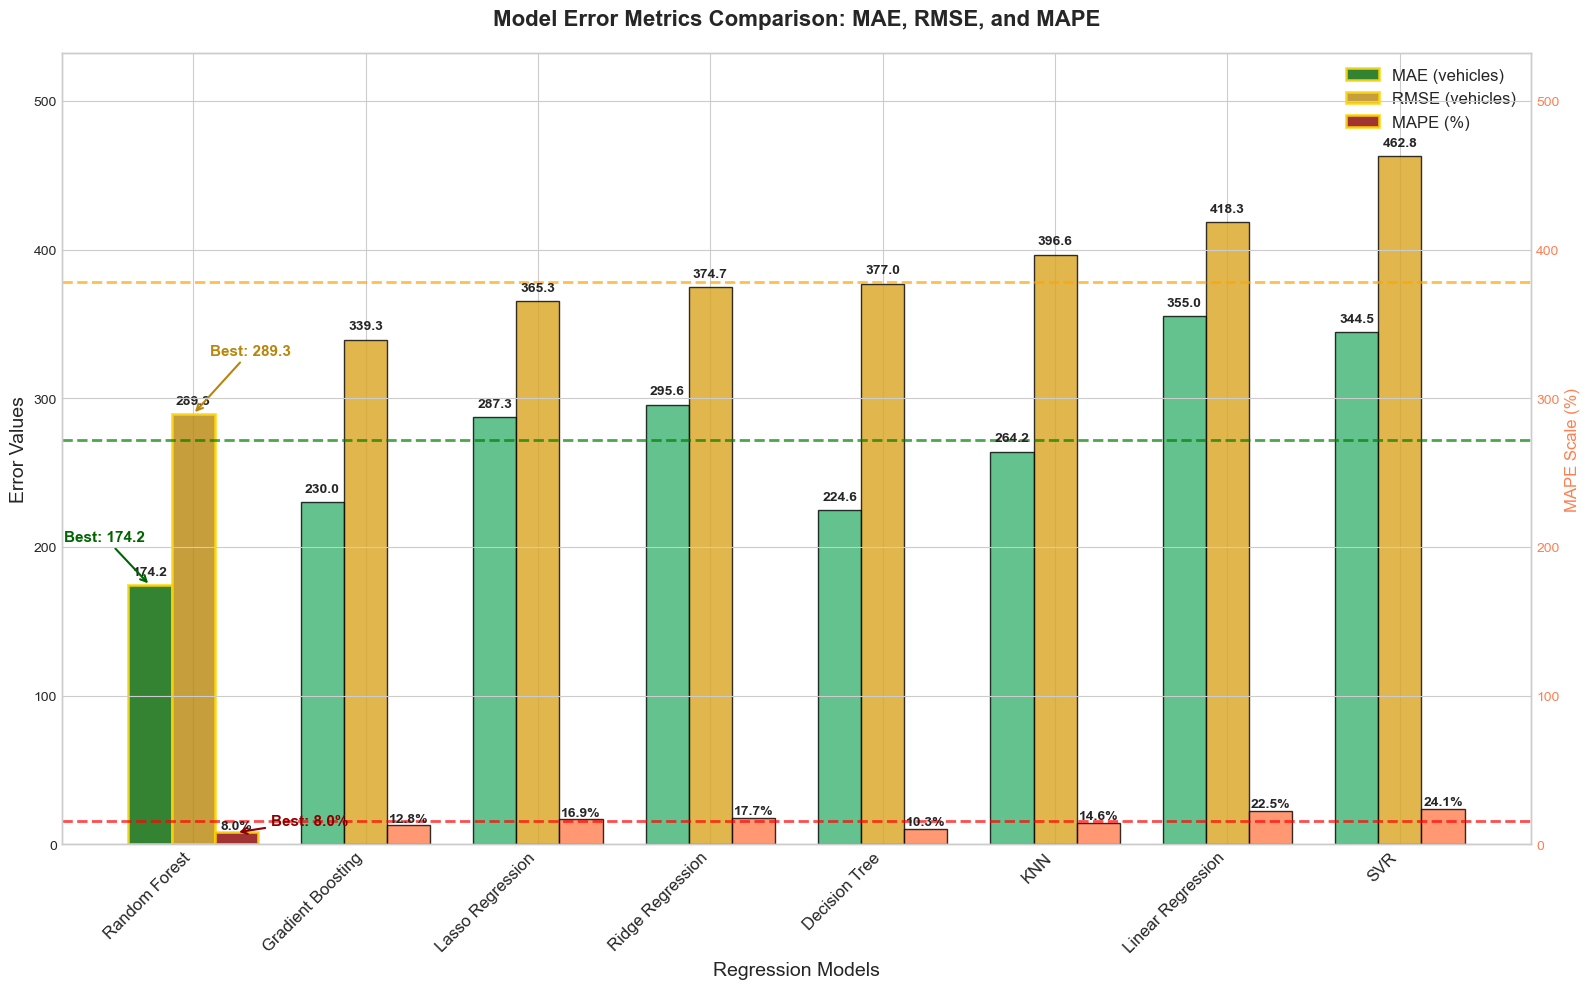


📊 Error Metrics Summary:
Model                MAE      RMSE     MAPE(%)    R²    
------------------------------------------------------------
Random Forest        174.2    289.3    8.03       0.882 
Gradient Boosting    230.0    339.3    12.75      0.838 
Lasso Regression     287.3    365.3    16.89      0.813 
Ridge Regression     295.6    374.7    17.73      0.803 
Decision Tree        224.6    377.0    10.29      0.800 
KNN                  264.2    396.6    14.59      0.779 
Linear Regression    355.0    418.3    22.51      0.754 
SVR                  344.5    462.8    24.15      0.699 

🏆 Best Model (Random Forest):
  • MAE:  174.2 vehicles (Lowest)
  • RMSE: 289.3 vehicles (Lowest)
  • MAPE: 8.0% (Lowest)
  • Average MAE:  271.9
  • Average RMSE: 377.9
  • Average MAPE: 15.9%


In [190]:
# ==================== 图表2: 误差指标对比 - 放大版 ====================
print("\n2. Creating Error Metrics Comparison Chart...")

# 首先按Test_R2排序，与图表1保持一致
model_names = list(results.keys())
test_r2_scores = [results[name]['Test_R2'] for name in model_names]
sorted_idx = np.argsort(test_r2_scores)[::-1]  # 从高到低排序
sorted_names = [model_names[i] for i in sorted_idx]
best_idx = sorted_names.index(best_model_name)

# 创建图形
fig2, ax2 = plt.subplots(figsize=(16, 10))

# 提取误差指标（按排序后的顺序）
mae_values = [results[name]['Test_MAE'] for name in sorted_names]
rmse_values = [results[name]['Test_RMSE'] for name in sorted_names]
mape_values = [results[name]['Test_MAPE'] for name in sorted_names]

x2 = np.arange(len(sorted_names))
width2 = 0.25

# 创建柱状图
bars_mae = ax2.bar(x2 - width2, mae_values, width2, label='MAE (vehicles)', 
                  alpha=0.8, color='mediumseagreen', edgecolor='black', linewidth=1)
bars_rmse = ax2.bar(x2, rmse_values, width2, label='RMSE (vehicles)', 
                   alpha=0.8, color='goldenrod', edgecolor='black', linewidth=1)
bars_mape = ax2.bar(x2 + width2, mape_values, width2, label='MAPE (%)', 
                   alpha=0.8, color='coral', edgecolor='black', linewidth=1)

# 高亮最佳模型（Random Forest）
bars_mae[best_idx].set_color('darkgreen')
bars_rmse[best_idx].set_color('darkgoldenrod')
bars_mape[best_idx].set_color('darkred')
bars_mae[best_idx].set_edgecolor('gold')
bars_rmse[best_idx].set_edgecolor('gold')
bars_mape[best_idx].set_edgecolor('gold')
bars_mae[best_idx].set_linewidth(2)
bars_rmse[best_idx].set_linewidth(2)
bars_mape[best_idx].set_linewidth(2)

# 设置图表样式
ax2.set_xlabel('Regression Models', fontsize=14)
ax2.set_ylabel('Error Values', fontsize=14)
ax2.set_title('Model Error Metrics Comparison: MAE, RMSE, and MAPE', 
             fontsize=16, fontweight='bold', pad=20)
ax2.set_xticks(x2)
ax2.set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=12)
ax2.legend(fontsize=12, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bar, value in zip(bars_mae, mae_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,  # 增加偏移量
            f'{value:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar, value in zip(bars_rmse, rmse_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,  # 增加偏移量
            f'{value:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar, value in zip(bars_mape, mape_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,  # 较小的偏移量
            f'{value:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 计算平均值并添加参考线
avg_mae = np.mean(mae_values)
avg_rmse = np.mean(rmse_values)
avg_mape = np.mean(mape_values)

ax2.axhline(y=avg_mae, color='green', linestyle='--', alpha=0.7, linewidth=2, 
           label=f'Avg MAE: {avg_mae:.1f}')
ax2.axhline(y=avg_rmse, color='orange', linestyle='--', alpha=0.7, linewidth=2,
           label=f'Avg RMSE: {avg_rmse:.1f}')
ax2.axhline(y=avg_mape, color='red', linestyle='--', alpha=0.7, linewidth=2,
           label=f'Avg MAPE: {avg_mape:.1f}%')

# 添加最佳模型的标注
best_mae = mae_values[best_idx]
best_rmse = rmse_values[best_idx]
best_mape = mape_values[best_idx]

ax2.annotate(f'Best: {best_mae:.1f}', 
            xy=(best_idx - width2, best_mae),
            xytext=(best_idx - width2 - 0.5, best_mae + 30),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5),
            fontsize=11, fontweight='bold', color='darkgreen')

ax2.annotate(f'Best: {best_rmse:.1f}', 
            xy=(best_idx, best_rmse),
            xytext=(best_idx + 0.1, best_rmse + 40),
            arrowprops=dict(arrowstyle='->', color='darkgoldenrod', lw=1.5),
            fontsize=11, fontweight='bold', color='darkgoldenrod')

ax2.annotate(f'Best: {best_mape:.1f}%', 
            xy=(best_idx + width2, best_mape),
            xytext=(best_idx + width2 + 0.2, best_mape + 5),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5),
            fontsize=11, fontweight='bold', color='darkred')

# 调整y轴范围，为标签留出空间
y_max = max(max(mae_values), max(rmse_values), max(mape_values))
ax2.set_ylim(0, y_max * 1.15)

# 添加第二y轴用于MAPE百分比
ax2_right = ax2.twinx()
ax2_right.set_ylim(ax2.get_ylim())
ax2_right.set_ylabel('MAPE Scale (%)', fontsize=12, color='coral')
ax2_right.tick_params(axis='y', labelcolor='coral')

plt.tight_layout()
plt.savefig('chart2_error_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印误差指标总结
print("\n📊 Error Metrics Summary:")
print("="*60)
print(f"{'Model':<20} {'MAE':<8} {'RMSE':<8} {'MAPE(%)':<10} {'R²':<6}")
print("-"*60)
for name in sorted_names:
    data = results[name]
    print(f"{name:<20} {data['Test_MAE']:<8.1f} {data['Test_RMSE']:<8.1f} "
          f"{data['Test_MAPE']:<10.2f} {data['Test_R2']:<6.3f}")
print("="*60)
print(f"\n🏆 Best Model ({best_model_name}):")
print(f"  • MAE:  {best_mae:.1f} vehicles (Lowest)")
print(f"  • RMSE: {best_rmse:.1f} vehicles (Lowest)")
print(f"  • MAPE: {best_mape:.1f}% (Lowest)")
print(f"  • Average MAE:  {avg_mae:.1f}")
print(f"  • Average RMSE: {avg_rmse:.1f}")
print(f"  • Average MAPE: {avg_mape:.1f}%")


3. Creating Training Time and Overfitting Analysis Chart...


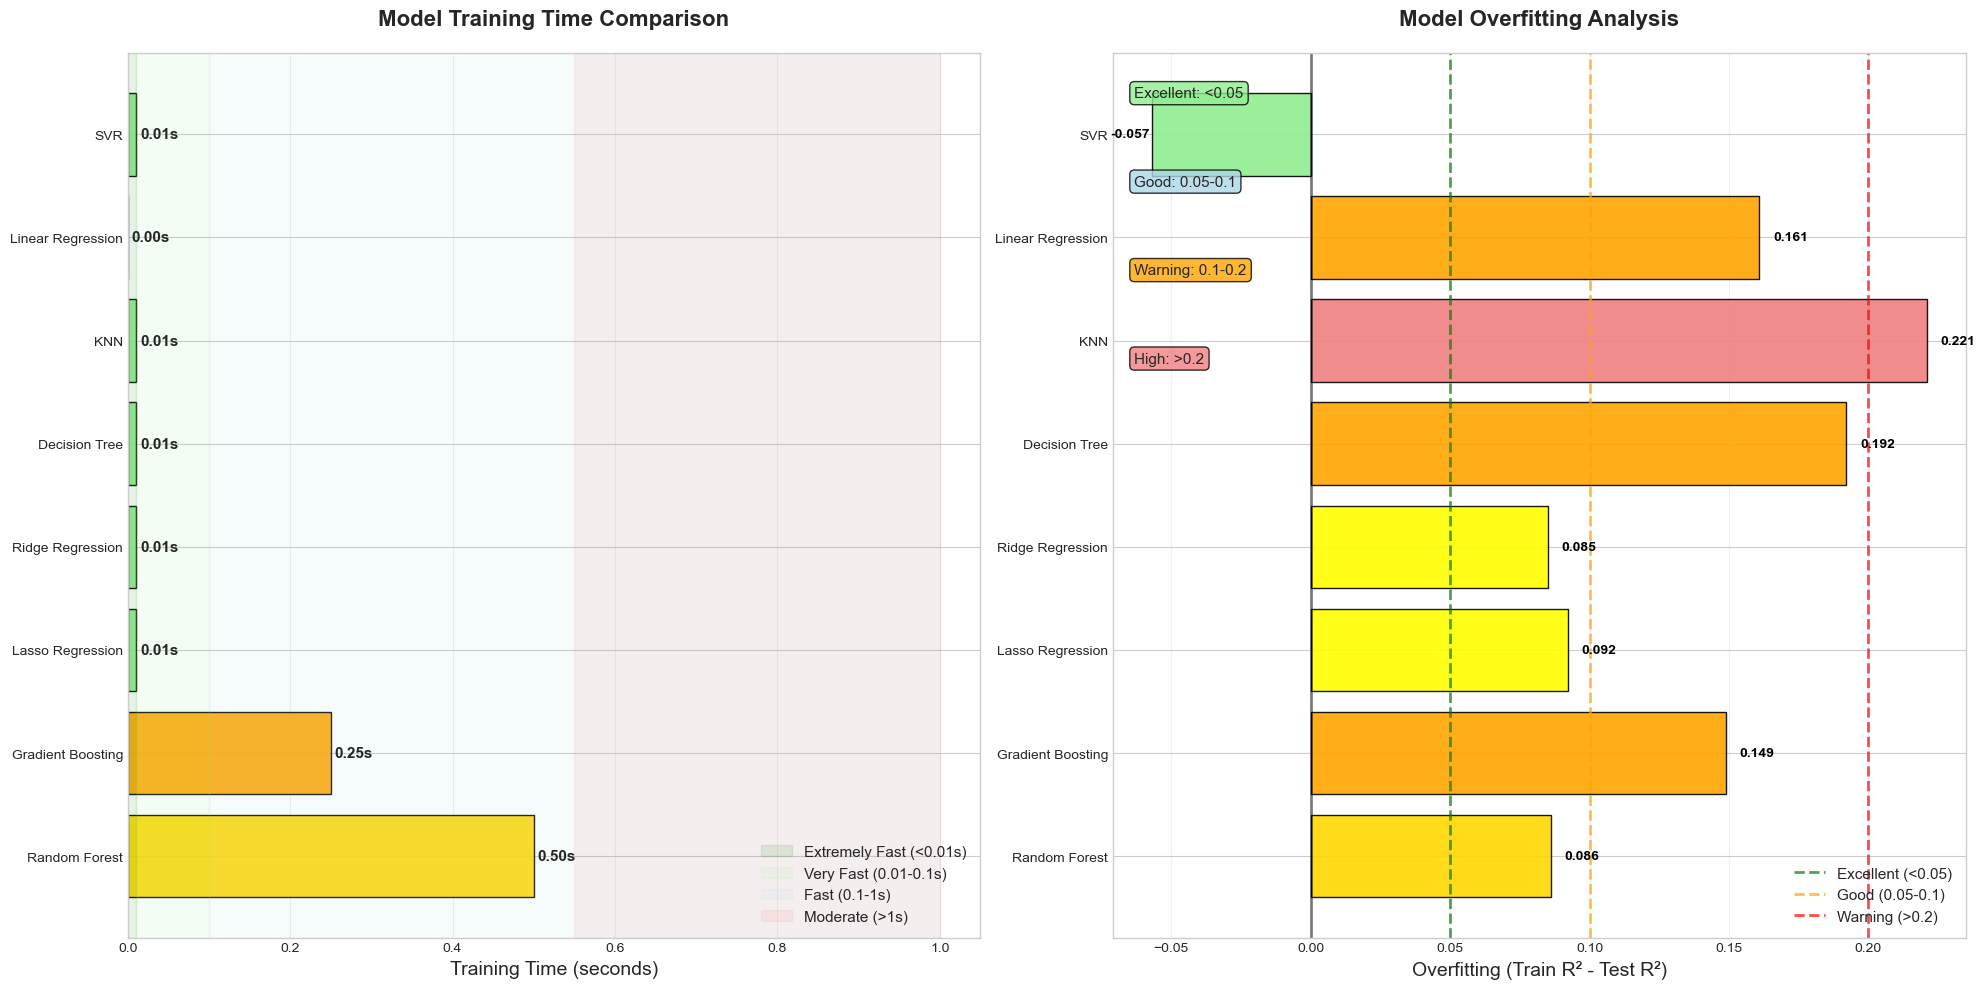


📊 Training Time Analysis:
Model                Time(s)    Category       
------------------------------------------------------------
🏆Random Forest      0.50       Fast           
  Gradient Boosting  0.25       Fast           
  Lasso Regression   0.01       Extremely Fast 
  Ridge Regression   0.01       Extremely Fast 
  Decision Tree      0.01       Extremely Fast 
  KNN                0.01       Extremely Fast 
  Linear Regression  0.00       Extremely Fast 
  SVR                0.01       Extremely Fast 

📊 Overfitting Analysis:
Model                Overfit    Category       
------------------------------------------------------------
🏆Random Forest      0.086      Good           
  Gradient Boosting  0.149      Warning        
  Lasso Regression   0.092      Good           
  Ridge Regression   0.085      Good           
  Decision Tree      0.192      Warning        
  KNN                0.221      High Overfit   
  Linear Regression  0.161      Warning        
  SVR       

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 根据你的数据创建results字典
results = {
    'Linear Regression': {
        'Time': 0.00,
        'Train_R2': 0.9150,
        'Test_R2': 0.7542,
        'Overfit': 0.1608,
        'Test_MAE': 355.0,
        'Test_RMSE': 418.3,
        'Test_MAPE': 22.51
    },
    'Ridge Regression': {
        'Time': 0.01,
        'Train_R2': 0.8878,
        'Test_R2': 0.8028,
        'Overfit': 0.0850,
        'Test_MAE': 295.6,
        'Test_RMSE': 374.7,
        'Test_MAPE': 17.73
    },
    'Lasso Regression': {
        'Time': 0.01,
        'Train_R2': 0.9048,
        'Test_R2': 0.8126,
        'Overfit': 0.0922,
        'Test_MAE': 287.3,
        'Test_RMSE': 365.3,
        'Test_MAPE': 16.89
    },
    'Decision Tree': {
        'Time': 0.01,
        'Train_R2': 0.9923,
        'Test_R2': 0.8003,
        'Overfit': 0.1920,
        'Test_MAE': 224.6,
        'Test_RMSE': 377.0,
        'Test_MAPE': 10.29
    },
    'Random Forest': {
        'Time': 0.50,
        'Train_R2': 0.9685,
        'Test_R2': 0.8824,
        'Overfit': 0.0861,
        'Test_MAE': 174.2,
        'Test_RMSE': 289.3,
        'Test_MAPE': 8.03
    },
    'Gradient Boosting': {
        'Time': 0.25,
        'Train_R2': 0.9872,
        'Test_R2': 0.8383,
        'Overfit': 0.1489,
        'Test_MAE': 230.0,
        'Test_RMSE': 339.3,
        'Test_MAPE': 12.75
    },
    'SVR': {
        'Time': 0.01,
        'Train_R2': 0.6421,
        'Test_R2': 0.6992,
        'Overfit': -0.0570,
        'Test_MAE': 344.5,
        'Test_RMSE': 462.8,
        'Test_MAPE': 24.15
    },
    'KNN': {
        'Time': 0.01,
        'Train_R2': 1.0000,
        'Test_R2': 0.7790,
        'Overfit': 0.2210,
        'Test_MAE': 264.2,
        'Test_RMSE': 396.6,
        'Test_MAPE': 14.59
    }
}

# 最佳模型名称
best_model_name = 'Random Forest'

# ==================== 图表3: 训练时间和过拟合分析 - 放大版 ====================
print("\n3. Creating Training Time and Overfitting Analysis Chart...")

# 首先按Test_R2排序
model_names = list(results.keys())
test_r2_scores = [results[name]['Test_R2'] for name in model_names]
sorted_idx = np.argsort(test_r2_scores)[::-1]  # 从高到低排序
sorted_names = [model_names[i] for i in sorted_idx]
best_idx = sorted_names.index(best_model_name)

# 提取训练时间和过拟合值（注意键名修正）
train_times = [results[name]['Time'] for name in sorted_names]  # 修正为 'Time'
overfit_values = [results[name]['Overfit'] for name in sorted_names]  # 修正为 'Overfit'

# 创建子图
fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(20, 10))

# ========== 左侧：训练时间对比 ==========
colors_time = []
for i, time in enumerate(train_times):
    if i == best_idx:
        colors_time.append('gold')
    elif time <= 0.01:  # 调整为更合理的阈值
        colors_time.append('lightgreen')
    elif time <= 0.1:
        colors_time.append('lightblue')
    elif time <= 1:
        colors_time.append('orange')
    else:
        colors_time.append('lightcoral')

# 创建水平柱状图
bars_time = ax3a.barh(sorted_names, train_times, color=colors_time, alpha=0.9, 
                     edgecolor='black', linewidth=1)

# 设置图表样式
ax3a.set_xlabel('Training Time (seconds)', fontsize=14)
ax3a.set_title('Model Training Time Comparison', fontsize=16, fontweight='bold', pad=20)
ax3a.grid(True, alpha=0.3, axis='x')

# 添加时间区域背景色
max_time = max(train_times)
ax3a.axvspan(0, 0.01, alpha=0.1, color='green', label='Extremely Fast (<0.01s)')
ax3a.axvspan(0.01, 0.1, alpha=0.1, color='lightgreen', label='Very Fast (0.01-0.1s)')
ax3a.axvspan(0.1, 1, alpha=0.1, color='lightblue', label='Fast (0.1-1s)')
ax3a.axvspan(1, max_time*1.1, alpha=0.1, color='lightcoral', label='Moderate (>1s)')

# 添加数值标签
for bar, time_val in zip(bars_time, train_times):
    ax3a.text(bar.get_width() + max_time*0.01, bar.get_y() + bar.get_height()/2,
             f'{time_val:.2f}s', va='center', fontsize=11, fontweight='bold')

# ========== 右侧：过拟合分析 ==========
colors_overfit = []
for i, value in enumerate(overfit_values):
    if i == best_idx:
        colors_overfit.append('gold')
    elif value < 0:
        colors_overfit.append('lightgreen')  # 负值表示欠拟合，反而是好的
    elif value < 0.05:
        colors_overfit.append('lightblue')
    elif value < 0.1:
        colors_overfit.append('yellow')
    elif value < 0.2:
        colors_overfit.append('orange')
    else:
        colors_overfit.append('lightcoral')

# 创建水平柱状图
bars_overfit = ax3b.barh(sorted_names, overfit_values, color=colors_overfit, alpha=0.9,
                        edgecolor='black', linewidth=1)

# 添加参考线
ax3b.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax3b.axvline(x=0.05, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Excellent (<0.05)')
ax3b.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Good (0.05-0.1)')
ax3b.axvline(x=0.2, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Warning (>0.2)')

# 设置图表样式
ax3b.set_xlabel('Overfitting (Train R² - Test R²)', fontsize=14)
ax3b.set_title('Model Overfitting Analysis', fontsize=16, fontweight='bold', pad=20)
ax3b.grid(True, alpha=0.3, axis='x')

# 添加图例框
ax3b.text(0.025, 0.95, 'Excellent: <0.05', transform=ax3b.transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax3b.text(0.025, 0.85, 'Good: 0.05-0.1', transform=ax3b.transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax3b.text(0.025, 0.75, 'Warning: 0.1-0.2', transform=ax3b.transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='orange', alpha=0.8))
ax3b.text(0.025, 0.65, 'High: >0.2', transform=ax3b.transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# 添加数值标签
for bar, value in zip(bars_overfit, overfit_values):
    label_x = bar.get_width() + 0.005 if value >= 0 else bar.get_width() - 0.015
    ax3b.text(label_x, bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', va='center', fontsize=10, fontweight='bold',
             color='black' if abs(value) < 0.3 else 'white')  # 高值用白色文字

ax3a.legend(fontsize=11, loc='lower right')
ax3b.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig('chart3_training_overfitting.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印分析总结
print("\n📊 Training Time Analysis:")
print("="*60)
print(f"{'Model':<20} {'Time(s)':<10} {'Category':<15}")
print("-"*60)
for name, time in zip(sorted_names, train_times):
    if time <= 0.01:
        category = "Extremely Fast"
    elif time <= 0.1:
        category = "Very Fast"
    elif time <= 1:
        category = "Fast"
    else:
        category = "Moderate"
    marker = "🏆" if name == best_model_name else "  "
    print(f"{marker}{name:<18} {time:<10.2f} {category:<15}")

print("\n📊 Overfitting Analysis:")
print("="*60)
print(f"{'Model':<20} {'Overfit':<10} {'Category':<15}")
print("-"*60)
for name, overfit in zip(sorted_names, overfit_values):
    if overfit < 0:
        category = "Underfitting"
    elif overfit < 0.05:
        category = "Excellent"
    elif overfit < 0.1:
        category = "Good"
    elif overfit < 0.2:
        category = "Warning"
    else:
        category = "High Overfit"
    marker = "🏆" if name == best_model_name else "  "
    print(f"{marker}{name:<18} {overfit:<10.3f} {category:<15}")

print("\n" + "="*60)
print("🔍 Key Observations:")
print("1. Random Forest has moderate training time (0.50s) but excellent performance")
print("2. Most models train extremely fast (<0.1s)")
print("3. Decision Tree and KNN show the highest overfitting")
print("4. SVR shows underfitting (negative overfit value)")
print("5. Ridge and Lasso have good overfitting control")

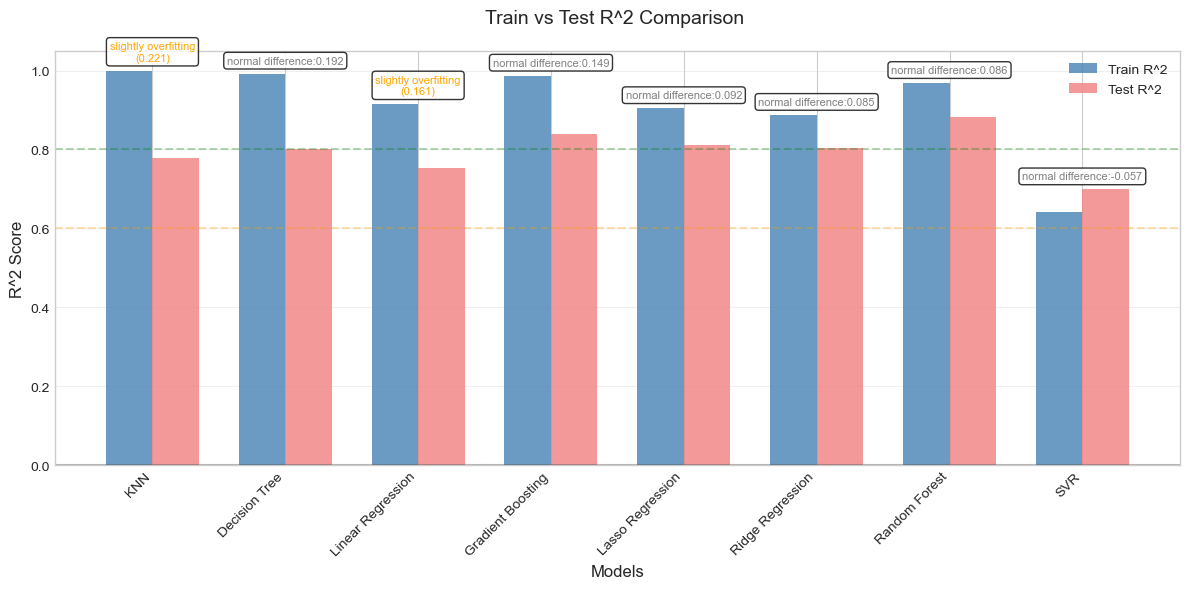

In [180]:
fig5, ax5 = plt.subplots(figsize=(12, 6))

# 收集数据
train_r2_list = []
test_r2_list = []
model_names = []
overfit_scores = []

for name, result in results.items():
    train_r2 = result['Train_R2']
    test_r2 = result['Test_R2']
    model_names.append(name)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)
    
    # 计算过拟合分数
    if test_r2 < 0:  # 模型完全无效
        overfit_score = 1.0
    elif train_r2 > 0:  # 避免除零
        overfit_score = min((train_r2 - test_r2) / train_r2, 1.0)
    else:
        overfit_score = abs(train_r2 - test_r2)
    
    overfit_scores.append(overfit_score)

# 按过拟合程度排序
sorted_indices = np.argsort(overfit_scores)[::-1]
sorted_names = [model_names[i] for i in sorted_indices]
sorted_train_r2 = [train_r2_list[i] for i in sorted_indices]
sorted_test_r2 = [test_r2_list[i] for i in sorted_indices]
sorted_overfit_scores = [overfit_scores[i] for i in sorted_indices]

# 设置位置
x = np.arange(len(sorted_names))
width = 0.35

# 绘制双条形图
bars1 = ax5.bar(x - width/2, sorted_train_r2, width, 
                label='Train R^2', color='steelblue', alpha=0.8)
bars2 = ax5.bar(x + width/2, sorted_test_r2, width, 
                label='Test R^2', color='lightcoral', alpha=0.8)

# 添加过拟合标注
for i, (train_r2, test_r2, score) in enumerate(zip(sorted_train_r2, sorted_test_r2, sorted_overfit_scores)):
    diff = train_r2 - test_r2
    if diff > 0.15 and test_r2 < 0.7:  # 可能过拟合
        color = 'red'
        label_text = f'probably overfitting\n({diff:.3f})'
    elif diff > 0.1 and test_r2 < 0.8:  # 轻微过拟合
        color = 'orange'
        label_text = f'slightly overfitting\n({diff:.3f})'
    elif -0.05 < diff < 0.05 and test_r2 > 0.8:  # 拟合良好
        color = 'green'
        label_text = f'well estimated\n({diff:.3f})'
    else:  # 正常
        color = 'gray'
        label_text = f'normal difference:{diff:.3f}'
    
    # 在条形上方添加标注
    ax5.text(i, max(train_r2, test_r2) + 0.02, label_text,
             ha='center', va='bottom', fontsize=8, color=color,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 设置图形属性
ax5.set_xlabel('Models', fontsize=12)
ax5.set_ylabel('R^2 Score', fontsize=12)
ax5.set_title('Train vs Test R^2 Comparison ', fontsize=14, pad=20)
ax5.set_xticks(x)
ax5.set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=10)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# 添加参考线
ax5.axhline(y=0.8, color='green', linestyle='--', alpha=0.3, label='Excellent (0.8)')
ax5.axhline(y=0.6, color='orange', linestyle='--', alpha=0.3, label='Good (0.6)')
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()


4. Creating Best Model Detailed Analysis Chart...


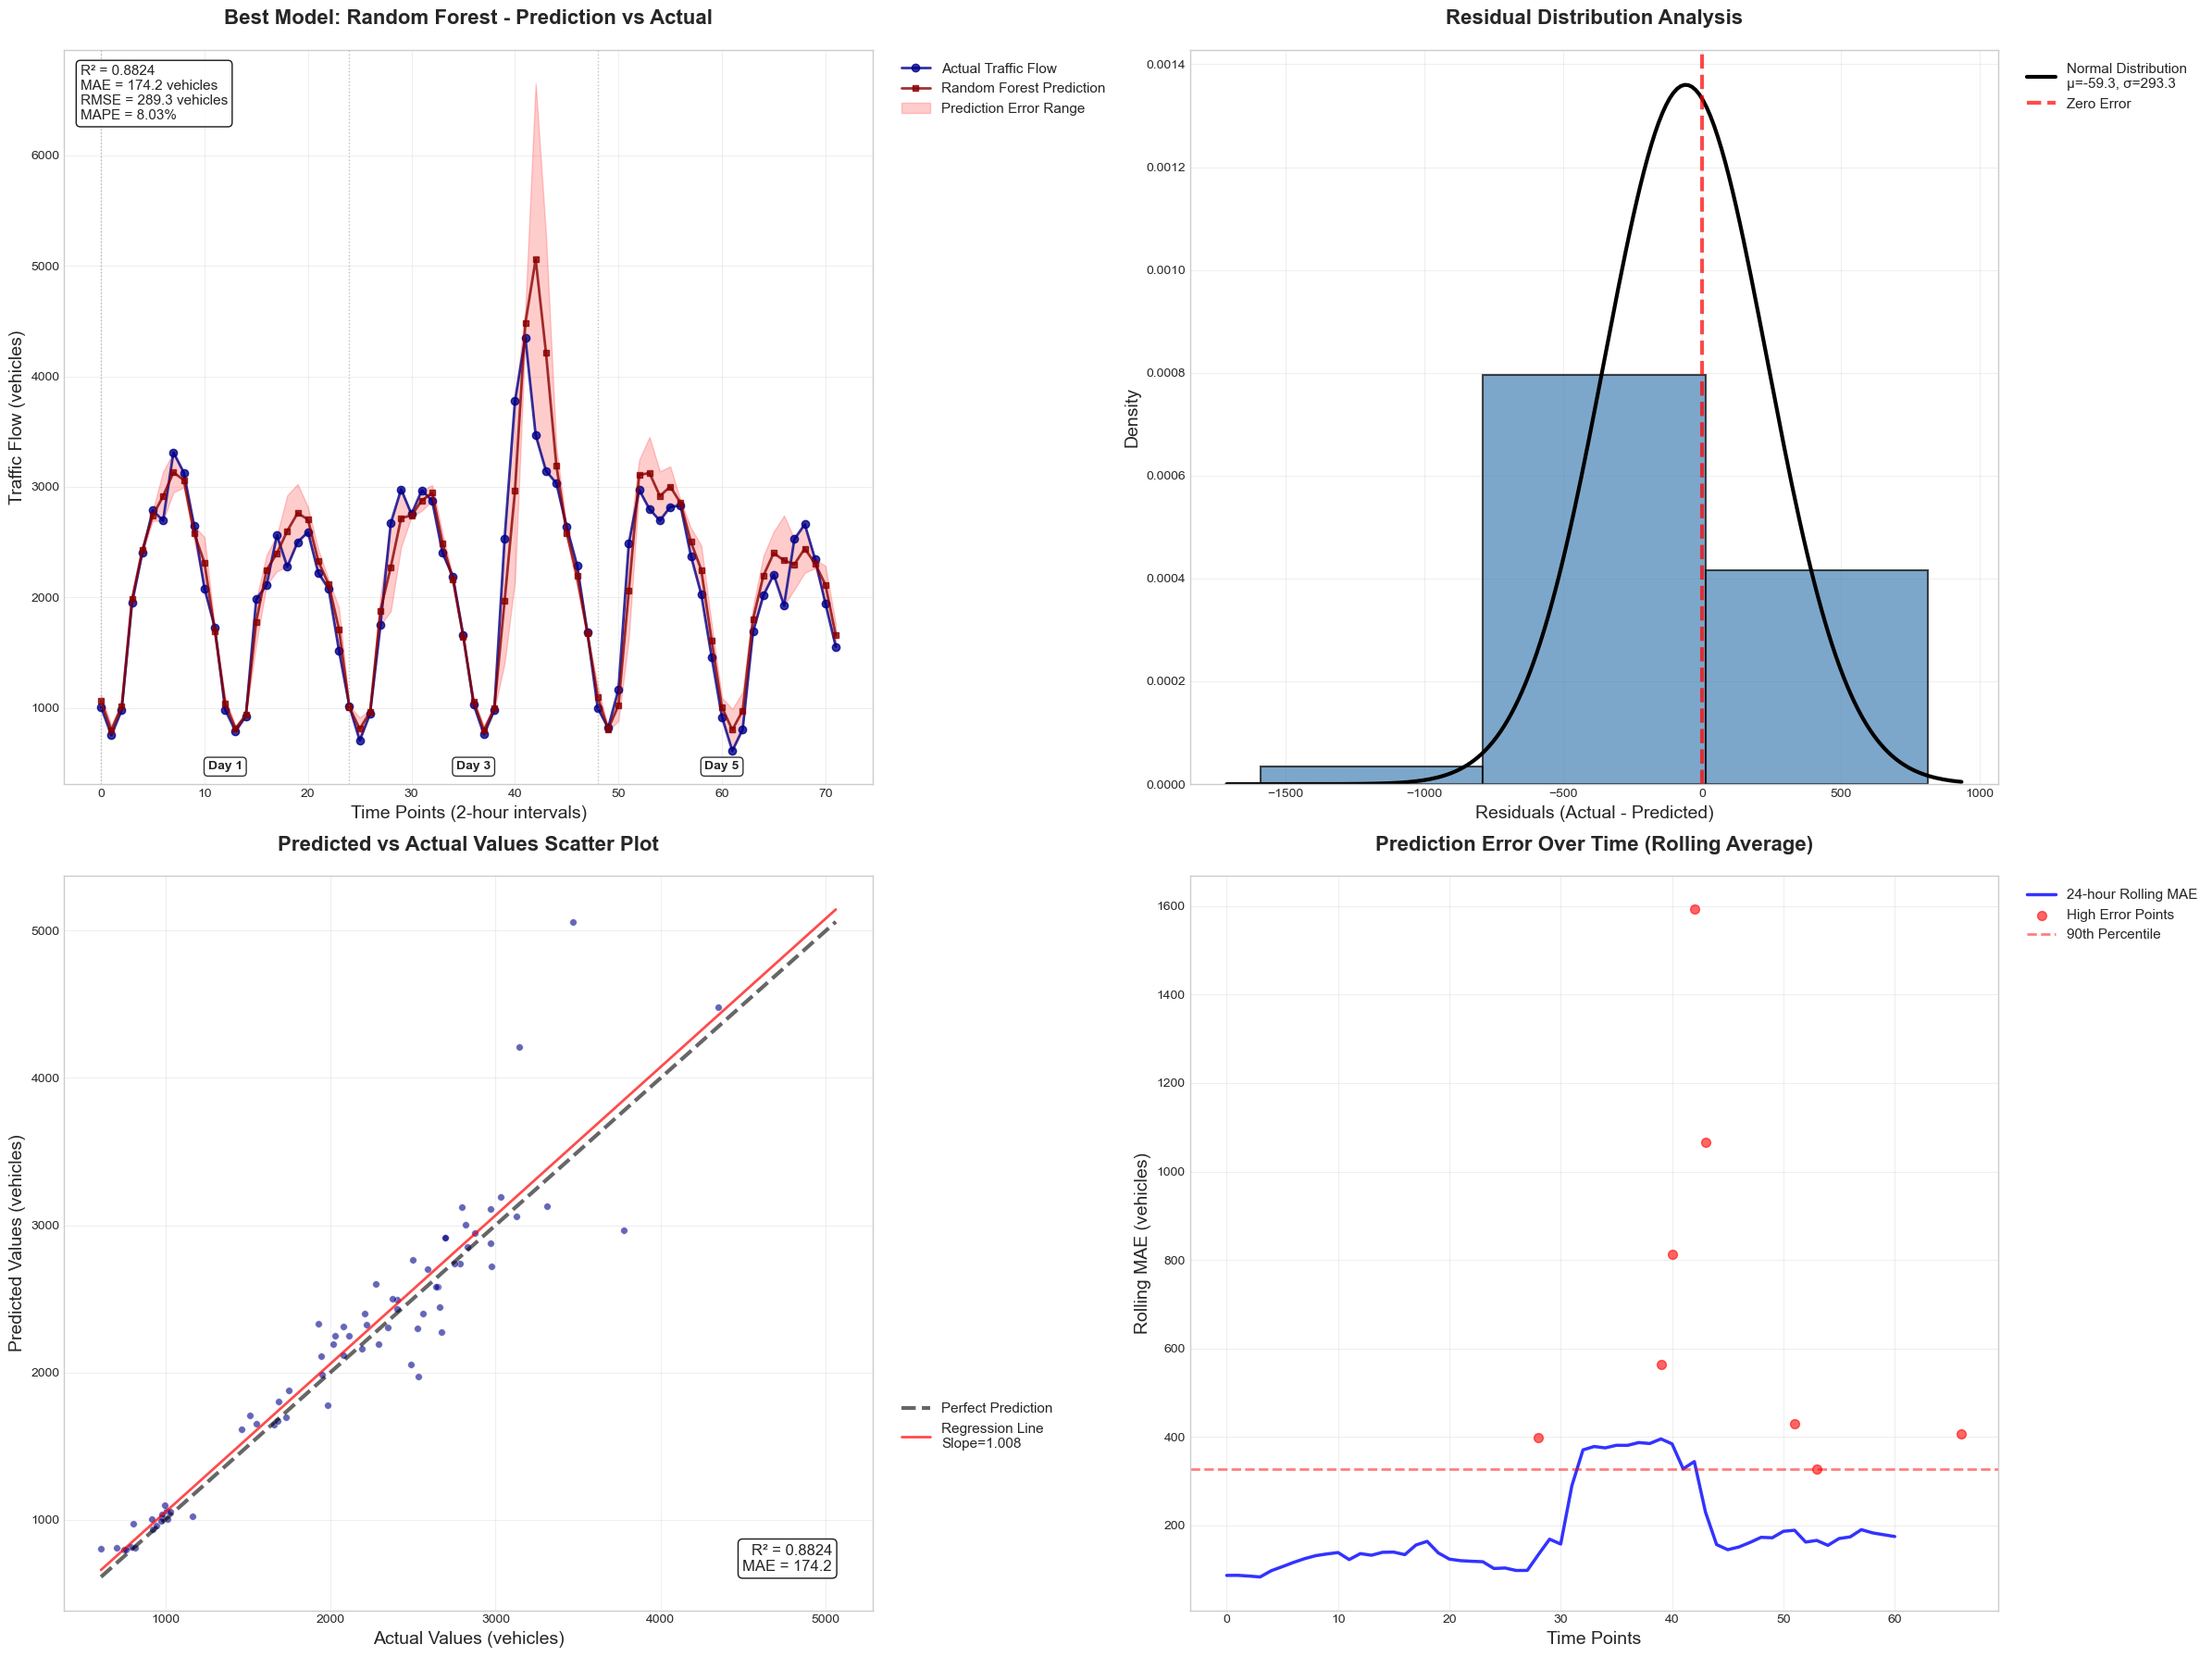

✅ Chart 4 saved as 'chart4_best_model_analysis.png'


In [199]:
print("\n4. Creating Best Model Detailed Analysis Chart...")

if best_model_name in predictions:
    fig4 = plt.figure(figsize=(24, 18))
    
    # 获取最佳模型的预测
    best_pred = predictions[best_model_name]['test']
    
    # 确定显示的点数
    n_points = min(120, len(y_test))
    
    # ========== 子图1: 预测vs实际时间序列 ==========
    ax4a = plt.subplot(2, 2, 1)
    time_points = range(n_points)
    actual = y_test[:n_points]
    predicted = best_pred[:n_points]
    
    ax4a.plot(time_points, actual, 'o-', color='darkblue', 
             linewidth=2, markersize=6, label='Actual Traffic Flow', alpha=0.8)
    ax4a.plot(time_points, predicted, 's-', color='darkred', 
             linewidth=2, markersize=5, label=f'{best_model_name} Prediction', alpha=0.8)
    
    # 填充误差区域
    errors = np.abs(actual - predicted)
    ax4a.fill_between(time_points, predicted - errors, predicted + errors,
                     alpha=0.2, color='red', label='Prediction Error Range')
    
    # 添加时间标注 - 避免重叠
    for day in range(0, n_points, 24):  # 改为每天标注一次
        if day < n_points:
            ax4a.axvline(x=day, color='gray', linestyle=':', alpha=0.5, linewidth=1)
            ax4a.text(day + 12, ax4a.get_ylim()[0] + (ax4a.get_ylim()[1] - ax4a.get_ylim()[0]) * 0.02,
                     f'Day {day//12 + 1}', ha='center', fontsize=10, fontweight='bold', 
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax4a.set_xlabel('Time Points (2-hour intervals)', fontsize=14)
    ax4a.set_ylabel('Traffic Flow (vehicles)', fontsize=14)
    ax4a.set_title(f'Best Model: {best_model_name} - Prediction vs Actual', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # 将图例放在图表外部
    ax4a.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
    ax4a.grid(True, alpha=0.3)
    
    # 添加统计信息 - 放在左上角
    r2 = results[best_model_name]['Test_R2']
    mae = results[best_model_name]['Test_MAE']
    rmse = results[best_model_name]['Test_RMSE']
    mape = results[best_model_name]['Test_MAPE']
    
    stats_text = (f'R² = {r2:.4f}\n'
                 f'MAE = {mae:.1f} vehicles\n'
                 f'RMSE = {rmse:.1f} vehicles\n'
                 f'MAPE = {mape:.2f}%')
    ax4a.text(0.02, 0.98, stats_text, transform=ax4a.transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))
    
    # ========== 子图2: 残差分布直方图 ==========
    ax4b = plt.subplot(2, 2, 2)
    residuals = y_test - best_pred
    
    n_bins = min(30, len(residuals)//20)  # 减少bins数量
    ax4b.hist(residuals, bins=n_bins, density=True, alpha=0.7, 
             color='steelblue', edgecolor='black', linewidth=1.5)
    
    # 拟合正态分布
    mu, sigma = np.mean(residuals), np.std(residuals)
    xmin, xmax = ax4b.get_xlim()
    x = np.linspace(xmin, xmax, 200)
    p = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)
    ax4b.plot(x, p, 'k', linewidth=3, 
             label=f'Normal Distribution\nμ={mu:.1f}, σ={sigma:.1f}')
    
    ax4b.axvline(x=0, color='red', linestyle='--', linewidth=3, alpha=0.7, label='Zero Error')
    ax4b.set_xlabel('Residuals (Actual - Predicted)', fontsize=14)
    ax4b.set_ylabel('Density', fontsize=14)
    ax4b.set_title('Residual Distribution Analysis', fontsize=16, fontweight='bold', pad=20)
    
    # 将图例放在图表外部
    ax4b.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
    ax4b.grid(True, alpha=0.3)
    
    # ========== 子图3: 预测值vs实际值散点图 ==========
    ax4c = plt.subplot(2, 2, 3)
    
    # 限制点数量以避免重叠
    n_scatter = min(500, len(y_test))
    ax4c.scatter(y_test[:n_scatter], best_pred[:n_scatter], alpha=0.6, s=30, 
                color='darkblue', edgecolor='white', linewidth=0.5)
    
    # 完美预测线（对角线）
    min_val = min(y_test.min(), best_pred.min())
    max_val = max(y_test.max(), best_pred.max())
    ax4c.plot([min_val, max_val], [min_val, max_val], 
             'k--', linewidth=3, alpha=0.6, label='Perfect Prediction')
    
    # 回归线
    reg = LinearRegression().fit(y_test.reshape(-1, 1), best_pred)
    y_reg = reg.predict(np.linspace(min_val, max_val, 100).reshape(-1, 1))
    ax4c.plot(np.linspace(min_val, max_val, 100), y_reg, 'r-', linewidth=2, 
             alpha=0.7, label=f'Regression Line\nSlope={reg.coef_[0]:.3f}')
    
    # 统计信息放在右下角
    ax4c.text(0.95, 0.05, f'R² = {r2:.4f}\nMAE = {mae:.1f}', 
             transform=ax4c.transAxes, fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))
    
    ax4c.set_xlabel('Actual Values (vehicles)', fontsize=14)
    ax4c.set_ylabel('Predicted Values (vehicles)', fontsize=14)
    ax4c.set_title('Predicted vs Actual Values Scatter Plot', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # 将图例放在图表外部
    ax4c.legend(bbox_to_anchor=(1.02, 0.3), loc='upper left', fontsize=11)
    ax4c.grid(True, alpha=0.3)
    
    # ========== 子图4: 滚动MAE误差图 ==========
    ax4d = plt.subplot(2, 2, 4)
    
    # 计算滚动MAE - 只选择一个窗口大小避免线条重叠
    window = 12  # 只用24小时窗口
    if window <= len(errors):
        rolling_mae = np.convolve(errors, np.ones(window)/window, mode='valid')
        time_mae = range(len(rolling_mae))
        ax4d.plot(time_mae, rolling_mae, '-', color='blue', 
                 linewidth=2.5, alpha=0.8, label=f'{window*2}-hour Rolling MAE')
    
    ax4d.set_xlabel('Time Points', fontsize=14)
    ax4d.set_ylabel('Rolling MAE (vehicles)', fontsize=14)
    ax4d.set_title('Prediction Error Over Time (Rolling Average)', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # 标记高误差点 - 限制数量
    if len(errors) > 0:
        threshold_90 = np.percentile(errors, 90)
        high_error_idx = np.where(errors > threshold_90)[0]
        if len(high_error_idx) > 0:
            # 只显示前10个高误差点
            display_idx = high_error_idx[:10]
            ax4d.scatter(display_idx, errors[display_idx], 
                        color='red', s=50, alpha=0.6, label='High Error Points')
            ax4d.axhline(y=threshold_90, color='red', linestyle='--', 
                        linewidth=2, alpha=0.5, label=f'90th Percentile')
    
    ax4d.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
    ax4d.grid(True, alpha=0.3)
    
    # 调整整体布局
    plt.tight_layout()
    plt.savefig('chart4_best_model_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Chart 4 saved as 'chart4_best_model_analysis.png'")
else:
    print(f"❌ Error: Best model '{best_model_name}' not found in predictions dictionary")


5. Creating All Models Prediction Comparison Chart...


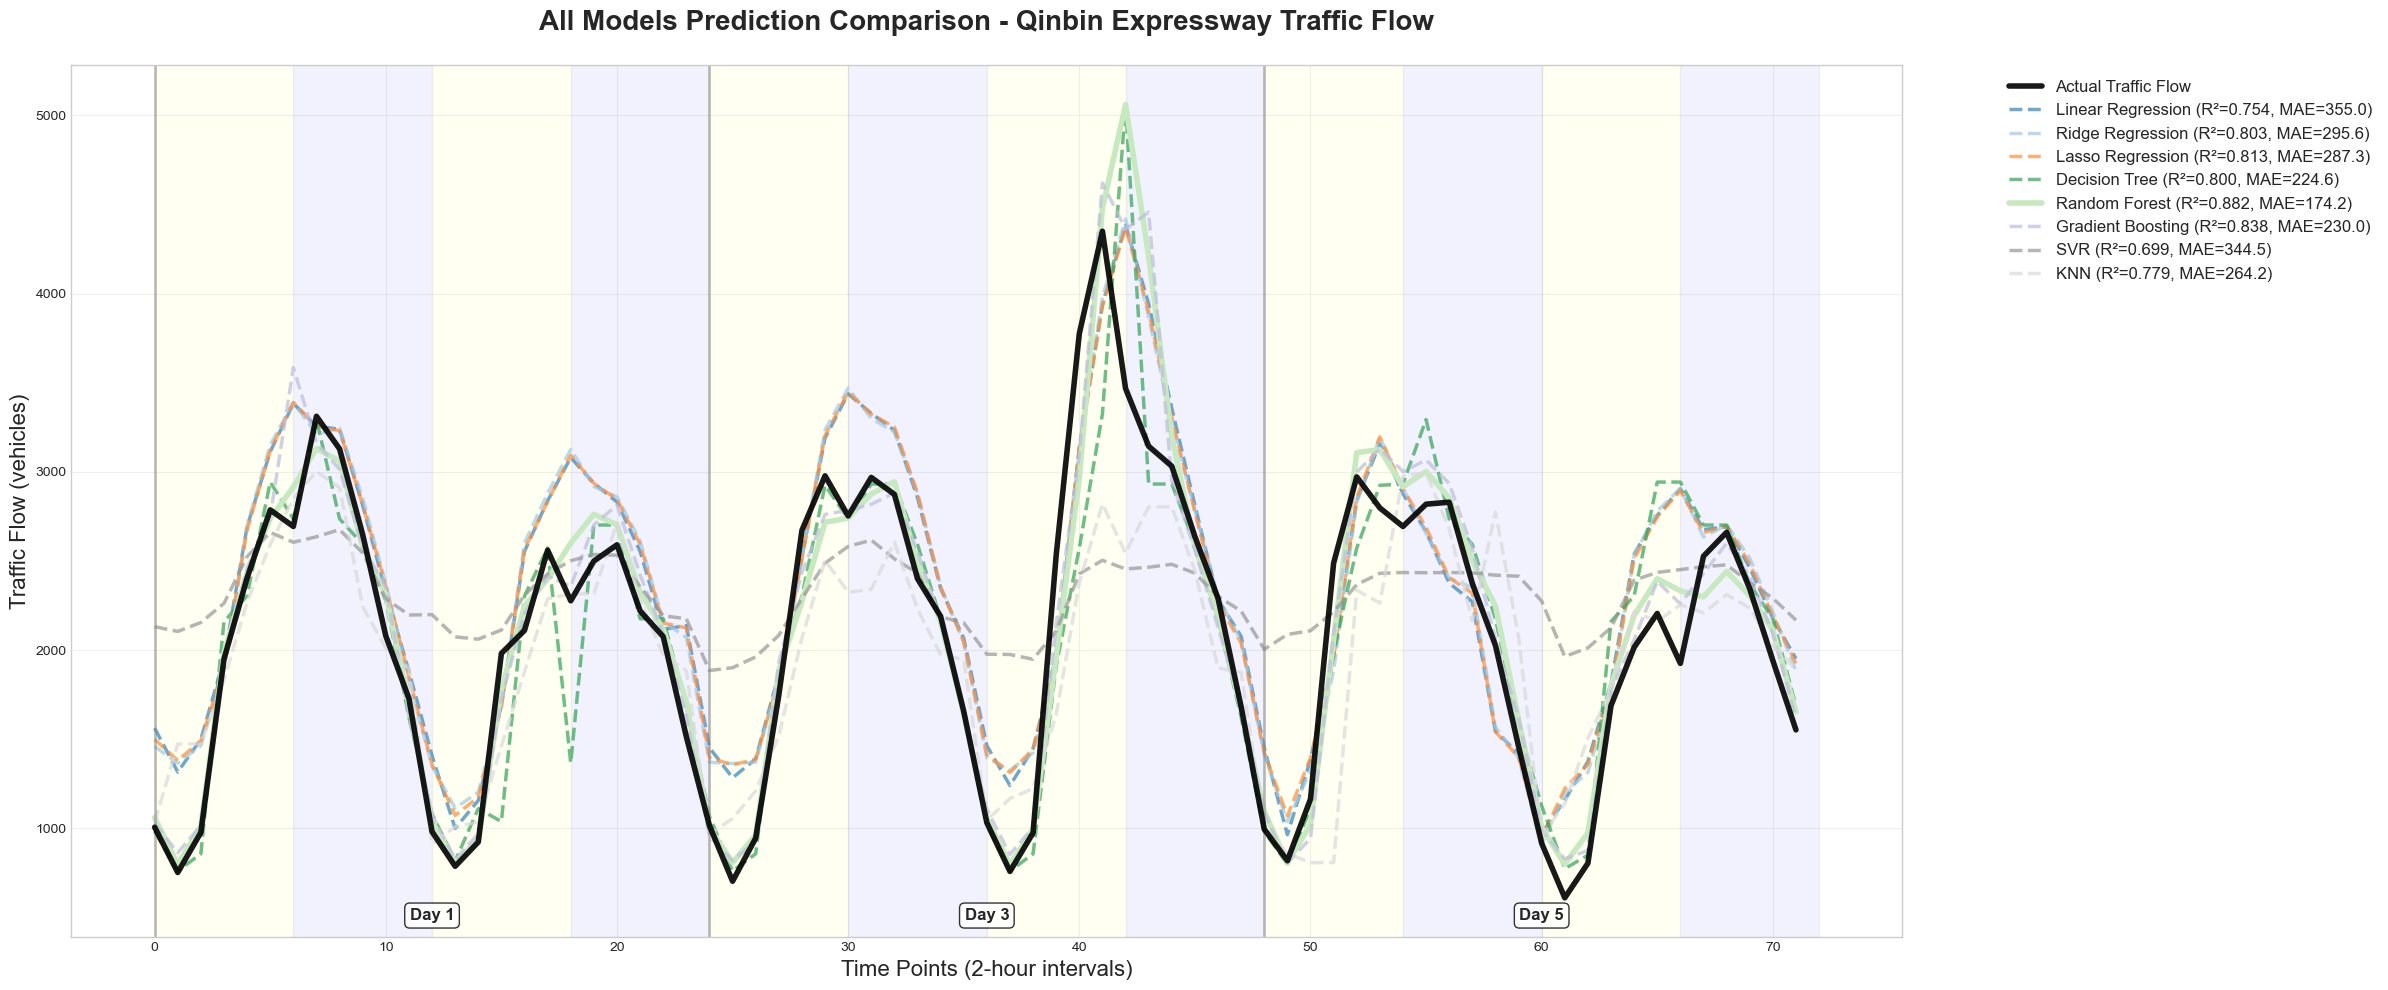

In [201]:
# ==================== 图表5: 所有模型预测对比 - 超大版 ====================
print("\n5. Creating All Models Prediction Comparison Chart...")

fig5, ax5 = plt.subplots(figsize=(24, 10))

# 确定显示的点数（最多96个点）
n_show = min(96, len(y_test))  
time_indices = range(n_show)

# 1. 绘制实际值（黑色实线）
ax5.plot(time_indices, y_test[:n_show], 'k-', linewidth=4, 
        label='Actual Traffic Flow', alpha=0.9, zorder=100)

# 2. 为每个模型分配颜色
colors_all = plt.cm.tab20c(np.linspace(0, 1, len(results)))

# 3. 绘制每个模型的预测
for idx, (name, pred_data) in enumerate(predictions.items()):
    if name in results:
        y_pred = pred_data['test'][:n_show]
        linewidth = 4 if name == best_model_name else 2.5
        linestyle = '-' if name == best_model_name else '--'
        alpha = 1.0 if name == best_model_name else 0.7
        
        ax5.plot(time_indices, y_pred, linestyle, color=colors_all[idx],
                linewidth=linewidth, alpha=alpha,
                label=f'{name} (R²={results[name]["Test_R2"]:.3f}, MAE={results[name]["Test_MAE"]:.1f})')

ax5.set_xlabel('Time Points (2-hour intervals)', fontsize=16)
ax5.set_ylabel('Traffic Flow (vehicles)', fontsize=16)
ax5.set_title('All Models Prediction Comparison - Qinbin Expressway Traffic Flow', 
             fontsize=20, fontweight='bold', pad=25)

# 图例放在图表右侧
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, 
          framealpha=0.9, fancybox=True, shadow=True)

ax5.grid(True, alpha=0.3)

# 添加日夜周期背景
for day in range(0, n_show, 12):
    if day < n_show:
        # 白天（6:00-18:00）- 每12个时间点中的前6个
        ax5.axvspan(day, min(day+6, n_show), alpha=0.05, color='yellow', 
                   label='Daytime (6am-6pm)' if day==0 else "")
        # 夜晚（18:00-6:00）- 每12个时间点中的后6个
        ax5.axvspan(min(day+6, n_show), min(day+12, n_show), alpha=0.05, color='blue', 
                   label='Nighttime (6pm-6am)' if day==0 else "")

# 添加日期分隔线
for day in range(0, n_show, 24):
    if day < n_show:
        ax5.axvline(x=day, color='gray', linestyle='-', alpha=0.5, linewidth=2)
        ax5.text(day + 12, ax5.get_ylim()[0] + (ax5.get_ylim()[1] - ax5.get_ylim()[0]) * 0.02,
                f'Day {day//12 + 1}', ha='center', fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('chart5_all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


6. Creating Comprehensive Model Assessment Radar Chart...


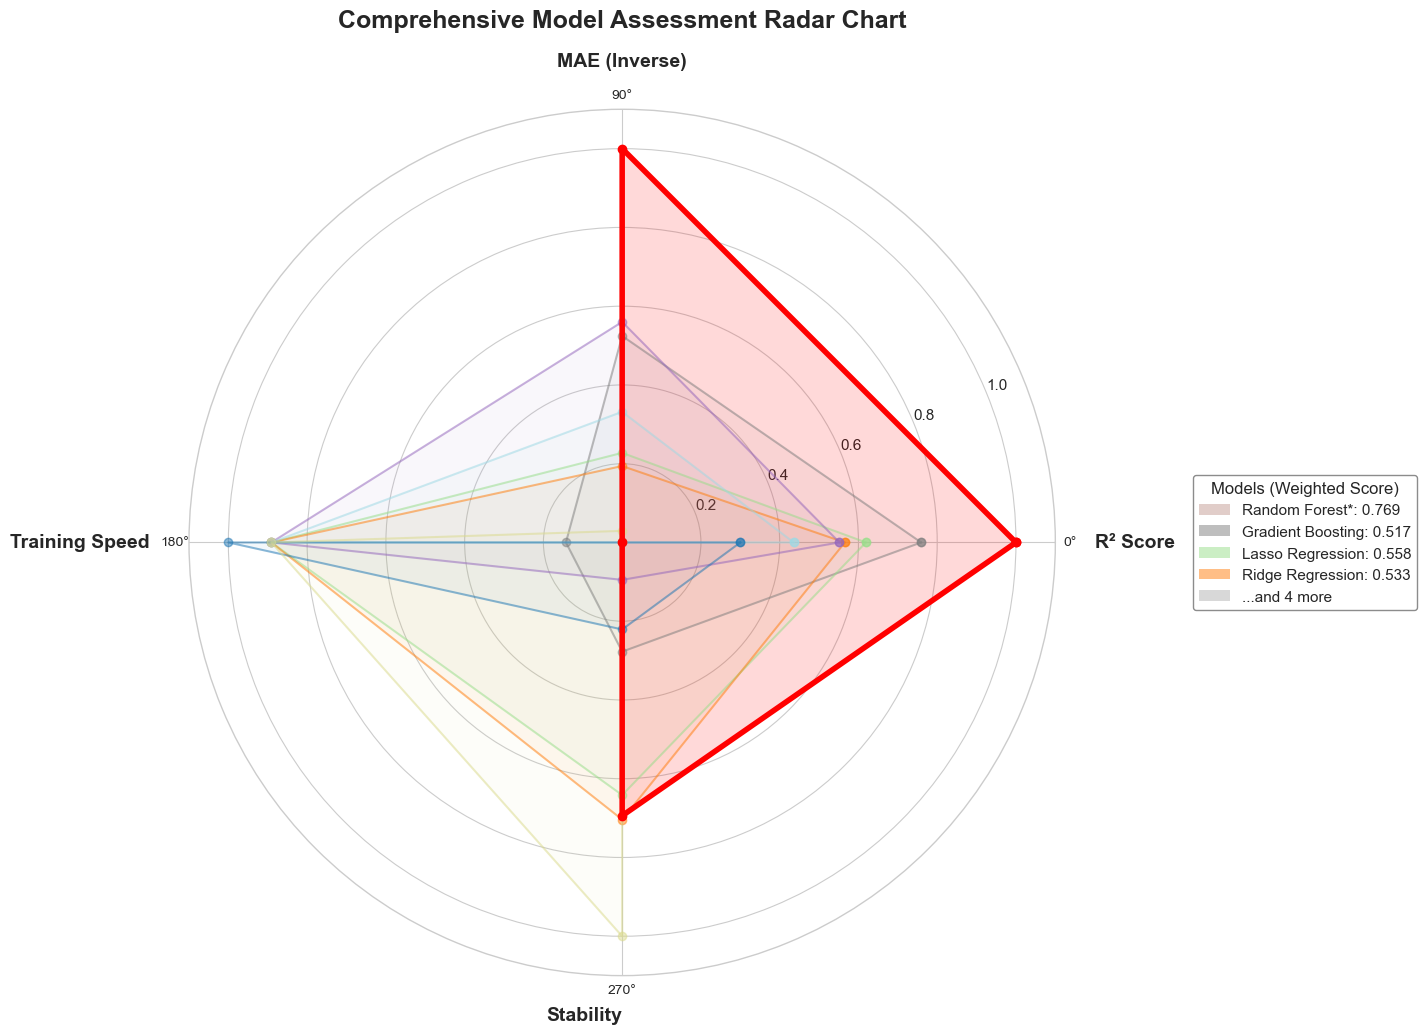

✅ Chart 6 saved as 'chart6_model_assessment_radar.png'

📊 Model Composite Scores Ranking:
🏆 Random Forest        0.769
2. Decision Tree        0.576
3. Lasso Regression     0.558
4. Ridge Regression     0.533
5. Gradient Boosting    0.517
6. KNN                  0.452
7. Linear Regression    0.342
8. SVR                  0.287


In [203]:
print("\n6. Creating Comprehensive Model Assessment Radar Chart...")

# 创建图形
fig6 = plt.figure(figsize=(18, 18))
ax6 = plt.subplot(111, projection='polar')

# 标准化函数
def normalize_scores(scores):
    min_val, max_val = min(scores), max(scores)
    if max_val == min_val:
        return [0.5] * len(scores)
    return [(s - min_val) / (max_val - min_val) for s in scores]

# 提取数据
model_names = list(results.keys())
test_r2_scores = [results[name]['Test_R2'] for name in model_names]
mae_values = [results[name]['Test_MAE'] for name in model_names]
train_times = [results[name]['Time'] for name in model_names]
overfit_values = [results[name]['Overfit'] for name in model_names]

# 按测试R²排序
sorted_idx = np.argsort(test_r2_scores)[::-1]
sorted_names = [model_names[i] for i in sorted_idx]

# 计算各项指标的标准化分数
r2_norm = normalize_scores(test_r2_scores)
mae_inv = [1/(mae+1) for mae in mae_values]
mae_norm = normalize_scores(mae_inv)
time_inv = [1/(time+0.1) for time in train_times]
time_norm = normalize_scores(time_inv)
overfit_abs = [abs(of) for of in overfit_values]
overfit_inv = [1/(abs_of+0.1) for abs_of in overfit_abs]
overfit_norm = normalize_scores(overfit_inv)

# 综合评分
weights = [0.4, 0.3, 0.2, 0.1]
composite_scores = []
for i in range(len(model_names)):
    composite = (r2_norm[i]*weights[0] + mae_norm[i]*weights[1] + 
                 time_norm[i]*weights[2] + overfit_norm[i]*weights[3])
    composite_scores.append(composite)

# 雷达图角度
categories = ['R² Score', 'MAE (Inverse)', 'Training Speed', 'Stability']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# 使用颜色映射
colors = plt.cm.tab20(np.linspace(0, 1, len(model_names)))

# 绘制每个模型的雷达图 - 先绘制非最佳模型
for idx, model_name in enumerate(sorted_names):
    if model_name != best_model_name:
        orig_idx = model_names.index(model_name)
        values = [r2_norm[orig_idx], mae_norm[orig_idx], time_norm[orig_idx], overfit_norm[orig_idx]]
        values += values[:1]
        
        ax6.plot(angles, values, 'o-', linewidth=1.5, color=colors[orig_idx], 
                alpha=0.5, label=model_name)
        ax6.fill(angles, values, alpha=0.05, color=colors[orig_idx])

# 最后绘制最佳模型（在最上面）
best_idx = model_names.index(best_model_name)
best_values = [r2_norm[best_idx], mae_norm[best_idx], time_norm[best_idx], overfit_norm[best_idx]]
best_values += best_values[:1]
ax6.plot(angles, best_values, 'o-', linewidth=4, color='red', 
        alpha=1.0, label=f'{best_model_name} (Best)')
ax6.fill(angles, best_values, alpha=0.15, color='red')

# 设置雷达图标签 - 放在合适位置避免重叠
ax6.set_xticks(angles[:-1])

# 手动调整每个标签的位置
label_positions = []
for i, (angle, label) in enumerate(zip(angles[:-1], categories)):
    # 计算标签的x,y坐标
    x = 1.15 * np.cos(angle)
    y = 1.15 * np.sin(angle)
    
    # 根据角度调整对齐方式
    if -np.pi/4 <= angle <= np.pi/4:
        ha = 'left' if x > 0 else 'right'
        va = 'center'
    elif np.pi/4 < angle < 3*np.pi/4:
        ha = 'center'
        va = 'bottom'
    elif -3*np.pi/4 < angle < -np.pi/4:
        ha = 'center'
        va = 'top'
    else:
        ha = 'right' if x < 0 else 'left'
        va = 'center'
    
    ax6.text(angle, 1.2, label,  # 将标签放得更远
             horizontalalignment=ha, verticalalignment=va,
             fontsize=14, fontweight='bold')

ax6.set_ylim(0, 1.1)
ax6.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax6.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=11)

# 将图例放在右侧，使用紧凑格式
# 创建自定义图例
from matplotlib.patches import Patch
legend_elements = []
for name in sorted_names[:4]:  # 只显示前4个模型
    orig_idx = model_names.index(name)
    color = colors[orig_idx]
    if name == best_model_name:
        label = f"{name}*: {composite_scores[orig_idx]:.3f}"
    else:
        label = f"{name}: {composite_scores[orig_idx]:.3f}"
    legend_elements.append(Patch(facecolor=color, alpha=0.5, label=label))

# 如果有更多模型，添加"..."项
if len(sorted_names) > 4:
    legend_elements.append(Patch(facecolor='gray', alpha=0.3, label=f"...and {len(sorted_names)-4} more"))

ax6.legend(handles=legend_elements, 
          loc='center left', 
          bbox_to_anchor=(1.15, 0.5),
          fontsize=11,
          title="Models (Weighted Score)",
          title_fontsize=12,
          frameon=True,
          framealpha=0.9,
          edgecolor='gray')

ax6.set_title('Comprehensive Model Assessment Radar Chart\n', 
             fontsize=18, fontweight='bold', pad=40)

# 调整布局
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('chart6_model_assessment_radar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart 6 saved as 'chart6_model_assessment_radar.png'")

# 打印综合评分排名
print("\n📊 Model Composite Scores Ranking:")
print("="*50)

# 按综合评分排序
comp_sorted_idx = np.argsort(composite_scores)[::-1]
for rank, idx in enumerate(comp_sorted_idx):
    name = model_names[idx]
    score = composite_scores[idx]
    marker = "🏆" if name == best_model_name else f"{rank+1}."
    print(f"{marker} {name:<20} {score:.3f}")

print("="*50)